Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import scipy.stats as stats
from math import sqrt

Reading the daily data csv file of the califorina state generated in the stage 2 

In [2]:
selected_state_daily = pd.read_csv('../../../../data/Stage_2/state_data_daily.csv')
selected_state_daily

,Dates,cases,deaths,population,new_cases,new_deaths
0,2022-05-30,8967578,90624,39512223,16380.0,90.0
1,2022-05-31,8973066,90626,39512223,5488.0,2.0
2,2022-06-01,8984553,90627,39512223,11487.0,1.0
3,2022-06-02,8986351,90627,39512223,1798.0,0.0
4,2022-06-03,8986351,90627,39512223,0.0,0.0
...,...,...,...,...,...,...
213,2022-12-29,10883092,97562,39512223,0.0,0.0
214,2022-12-30,10883092,97562,39512223,0.0,0.0
215,2022-12-31,10883092,97562,39512223,0.0,0.0
216,2023-01-01,10883092,97562,39512223,0.0,0.0


In [3]:
selected_state_daily = selected_state_daily.iloc[2:].reset_index(drop = True) #Removing the first two rows from the dataframe
selected_state_daily = selected_state_daily[:-2] #Removing the last two rows from the dataframe
selected_state_daily

,Dates,cases,deaths,population,new_cases,new_deaths
0,2022-06-01,8984553,90627,39512223,11487.0,1.0
1,2022-06-02,8986351,90627,39512223,1798.0,0.0
2,2022-06-03,8986351,90627,39512223,0.0,0.0
3,2022-06-04,8986351,90627,39512223,0.0,0.0
4,2022-06-05,8986351,90627,39512223,0.0,0.0
...,...,...,...,...,...,...
209,2022-12-27,10883092,97562,39512223,1612.0,0.0
210,2022-12-28,10883092,97562,39512223,0.0,0.0
211,2022-12-29,10883092,97562,39512223,0.0,0.0
212,2022-12-30,10883092,97562,39512223,0.0,0.0


In [4]:
selected_state_daily['Dates'] = pd.to_datetime(selected_state_daily['Dates']) #Converting the dates column into datetime
selected_state_daily

,Dates,cases,deaths,population,new_cases,new_deaths
0,2022-06-01,8984553,90627,39512223,11487.0,1.0
1,2022-06-02,8986351,90627,39512223,1798.0,0.0
2,2022-06-03,8986351,90627,39512223,0.0,0.0
3,2022-06-04,8986351,90627,39512223,0.0,0.0
4,2022-06-05,8986351,90627,39512223,0.0,0.0
...,...,...,...,...,...,...
209,2022-12-27,10883092,97562,39512223,1612.0,0.0
210,2022-12-28,10883092,97562,39512223,0.0,0.0
211,2022-12-29,10883092,97562,39512223,0.0,0.0
212,2022-12-30,10883092,97562,39512223,0.0,0.0


In [5]:
selected_state_daily['new_cases'].clip(lower=0, inplace = True) 
selected_state_daily['new_deaths'].clip(lower=0, inplace = True)

In [6]:
new_cases_list = selected_state_daily['new_cases'].tolist() # Taking new cases column into list
new_deaths_list = selected_state_daily['new_deaths'].tolist() #Taking new deaths column into list

Function which accepts a list and return the index of the first day and count from first day of infection

In [7]:
def first_day_new_cases_deaths(new_cases_deaths_list):
    first_day_list = []
    count = 1
    for idx,i in enumerate(new_cases_deaths_list):
        if(int(i)>=1):
            ind = idx #Finding the index 
            break
    for j in range(len(new_cases_deaths_list)):
        if(j>=ind):
            first_day_list.append(count) #Adding a count from that index
            count = count+1
        else:
            first_day_list.append(0)
    return ind,first_day_list   

Finding the first day of infection of california state using the above function first_day_new_cases_deaths by passing the new cases list 

In [8]:
ind_cases,first_day_cases = first_day_new_cases_deaths(new_cases_list)

In [9]:
selected_state_cases = selected_state_daily[['Dates','new_cases']] #Getting Dates and new cases column into separate dataframe
selected_state_cases['first_day'] = first_day_cases #Adding first_day column to the separated dataframe
#Considering the rows from the index where the new cases began
selected_state_cases = selected_state_cases.iloc[ind_cases:].reset_index(drop=True)
selected_state_cases

,Dates,new_cases,first_day
0,2022-06-01,11487.0,1
1,2022-06-02,1798.0,2
2,2022-06-03,0.0,3
3,2022-06-04,0.0,4
4,2022-06-05,0.0,5
...,...,...,...
209,2022-12-27,1612.0,210
210,2022-12-28,0.0,211
211,2022-12-29,0.0,212
212,2022-12-30,0.0,213


Function which accepts the dataframe and the columns and returns reshaped column values along with the model predicted trend line, confidence interval and prediction path for the one week ahead 

In [10]:
def lr_model(df,col1,col2):
    
    X = np.stack(df[col1]).reshape(-1,1) #Reshaping the first_day column obtained through col1
    X_1 = X.ravel()
    y = np.stack(df[col2]).reshape(-1,1) #Reshaping the new_cases or new_deaths column obtained through col2
    y_1 = y.ravel()
    lm=LinearRegression()
    lm.fit(X,y) # Fitting the X and y column data into a linear regression model
    y_pred=lm.predict(X) #Predicting the values from the trained model
    #y_pred_1 = y_pred.ravel()
    X1 = np.arange(len(X)+1,len(X)+8).reshape(-1, 1)      # getting the next 7 days 
    y_pred1 = lm.predict(X1) # Predicting the values for the one week ahead days
    print("One week ahead forecast using Linear Regression Model =",y_pred1)
    #ci = 0.1*(np.std(y)/np.mean(y))
    plt.figure(figsize=(12,8))
    #Plotting the confidence interval using the regplot of seaborn library
    o = sns.regplot(X_1,y_1,color = 'red',label = 'Confidence Interval')
    plt.scatter(X,y)
    plt.plot(X,y_pred,color ='red',linewidth = 2,label ='Linear Regression Model (Trend line)')
    
    plt.plot(X1,y_pred1,color = 'red',linewidth =7,label ='Linear Regression Model for one week ahead(Prediction Path)')
    plt.title('Linear Regression Model for '+col2,fontsize = 16)
    plt.xlabel('Days from first day of '+col2,fontsize=16)
    plt.ylabel(col2,fontsize=16)
    plt.legend()
    plt.show()
    #Calculating the root mean squared error by using the mean_squared_error function from sklearn.metrics
    rmse = sqrt(mean_squared_error(y,y_pred))
    print('RMSE of Linear Regression on ' +col2,rmse)
    return X,y

The above function might look similar to the one used in team stage. I used the same function in the team stage

One week ahead forecast using Linear Regression Model = [[2278.05633803]
 [2213.40074387]
 [2148.74514971]
 [2084.08955555]
 [2019.43396139]
 [1954.77836723]
 [1890.12277307]]


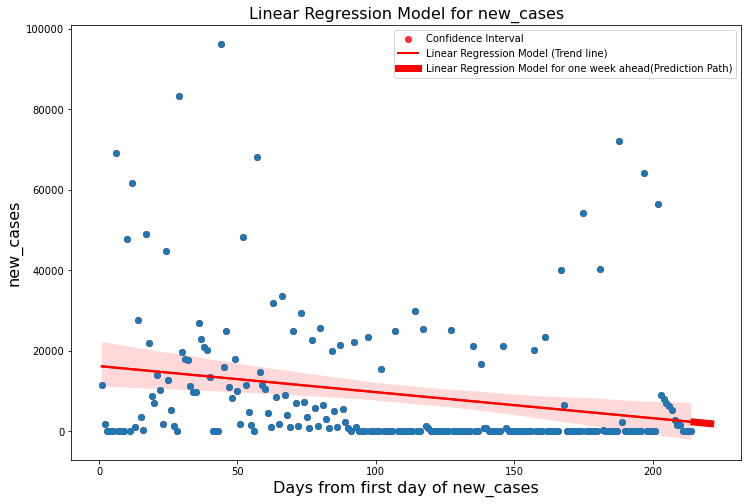

RMSE of Linear Regression on new_cases 16137.333352803971


In [11]:
X_cases,y_cases = lr_model(selected_state_cases,'first_day','new_cases') #Linear regression model for new cases across CA state

Function which accepts the values obtained from the lr_model function, degree and the column name. It is used for predicting the trend line, confidence interval and prediction path for one week ahead using the polynomial regression model with different degress.

In [12]:
def non_lr_model(X,y,n,col2):
    for i in n:
        X_1 = X.ravel()
        y_1 = y.ravel()
        plt.figure(figsize=(12,8))
        o = sns.regplot(X_1,y_1,color = 'red',label = 'Confidence Interval') #Plotting the confidence interval using regplot of seaborn library.
        plt.scatter(X,y)
        poly_reg = PolynomialFeatures(degree=i) 
        X_poly = poly_reg.fit_transform(X)
        lin_reg2 = LinearRegression()
        lin_reg2.fit(X_poly,y) # Fitting the X and y values using the polynomial regression model with the respective degree
        pred1 = lin_reg2.predict(X_poly) # Predicting the values from the trained model
        X1 = np.arange(len(X)+1,len(X)+8).reshape(-1, 1) #getting the next 7 days
        X_poly1 = poly_reg.fit_transform(X1)
        pred2 = lin_reg2.predict(X_poly1) # Predicting the values for one week ahead days
        plt.plot(X, pred1 ,color = 'black',linewidth=2, label='(Trend line)Non Linear (Polynomial) Regression Model with degree '+str(i))
        plt.plot(X1, pred2 ,color = 'black',linewidth =7, label='(Prediction Path)Non Linear (Polynomial) Regression Model for one week ahead with degree '+str(i))
        plt.title('Non Linear (Polynomial) Regression Model with degree %d for '%i +col2,fontsize = 16)
        plt.xlabel('Days from first day of '+col2,fontsize=16)
        plt.ylabel(col2,fontsize=16)
        plt.legend()
        plt.show()
        print('One week ahead forecast using Non-linear Regression Model with degree %d'%i,pred2)
        #Calculating the root mean squared error by using the mean_squared_error function from sklearn.metrics
        rmse = sqrt(mean_squared_error(y,pred1))
        print('RMSE of Non Linear (Polynomial) Regression with degree %d on '%i +col2,rmse)
    return

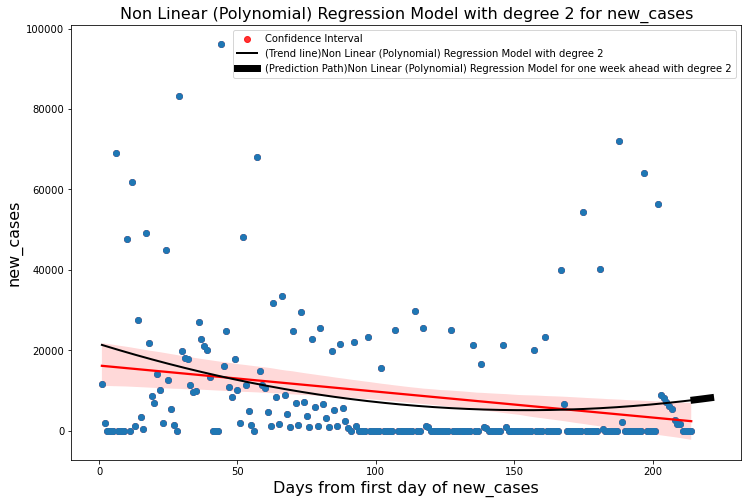

One week ahead forecast using Non-linear Regression Model with degree 2 [[7626.5207269 ]
 [7711.12460406]
 [7797.11051336]
 [7884.4784548 ]
 [7973.22842838]
 [8063.3604341 ]
 [8154.87447197]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_cases 15964.037613310162


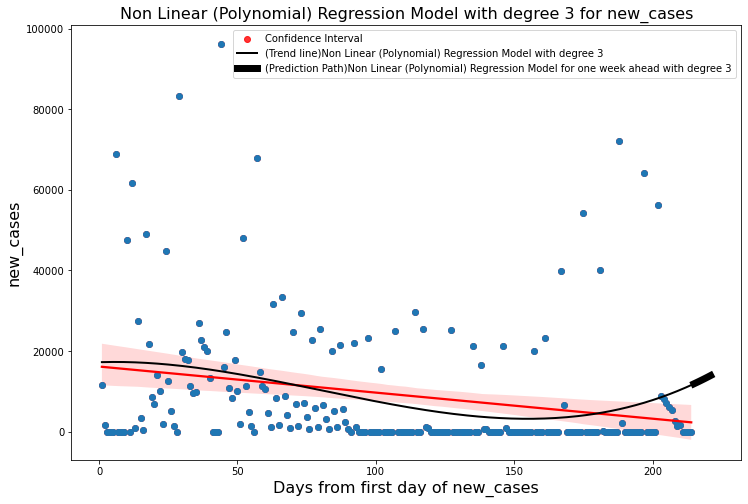

One week ahead forecast using Non-linear Regression Model with degree 3 [[11902.44464186]
 [12225.70473752]
 [12555.87131483]
 [12892.99529037]
 [13237.12758073]
 [13588.31910249]
 [13946.62077223]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_cases 15886.503816265138


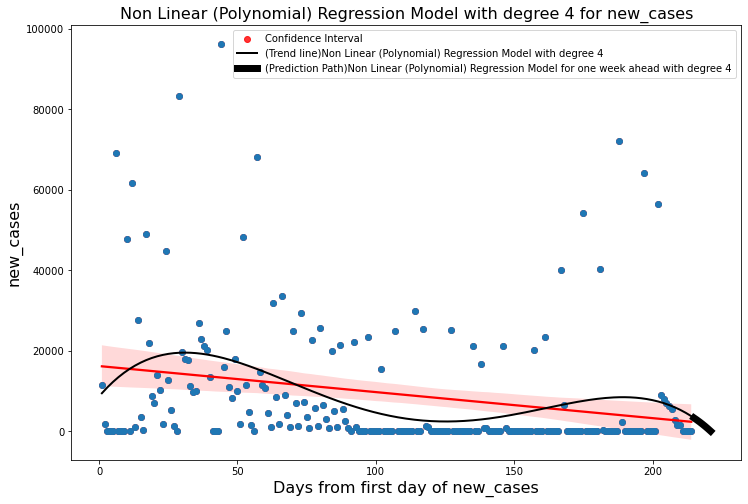

One week ahead forecast using Non-linear Regression Model with degree 4 [[3293.4337172 ]
 [2815.85558667]
 [2311.81567834]
 [1780.64731181]
 [1221.67722323]
 [ 634.22556529]
 [  17.60590722]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_cases 15648.667818651118


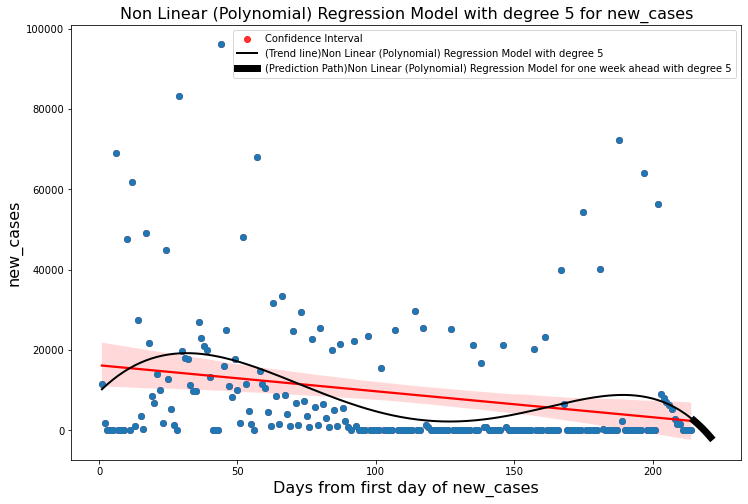

One week ahead forecast using Non-linear Regression Model with degree 5 [[ 2404.44410639]
 [ 1802.82387422]
 [ 1166.70213543]
 [  495.11581442]
 [ -212.91086612]
 [ -958.36644108]
 [-1742.25225881]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_cases 15646.672533720646


In [13]:
non_lr_model(X_cases,y_cases,[2,3,4,5],'new_cases') #Polynomial regression model for the new_cases across CA State

In [14]:
ind_deaths,first_day_deaths = first_day_new_cases_deaths(new_deaths_list)

In [15]:
selected_state_deaths = selected_state_daily[['Dates','new_deaths']]
selected_state_deaths['first_day'] = first_day_deaths
selected_state_deaths = selected_state_deaths.iloc[ind_deaths:].reset_index(drop=True)
selected_state_deaths

,Dates,new_deaths,first_day
0,2022-06-01,1.0,1
1,2022-06-02,0.0,2
2,2022-06-03,0.0,3
3,2022-06-04,0.0,4
4,2022-06-05,0.0,5
...,...,...,...
209,2022-12-27,0.0,210
210,2022-12-28,0.0,211
211,2022-12-29,0.0,212
212,2022-12-30,0.0,213


Linear Regression Model for the new_deaths across the CA State

One week ahead forecast using Linear Regression Model = [[30.58931157]
 [30.52024453]
 [30.45117748]
 [30.38211044]
 [30.3130434 ]
 [30.24397636]
 [30.17490931]]


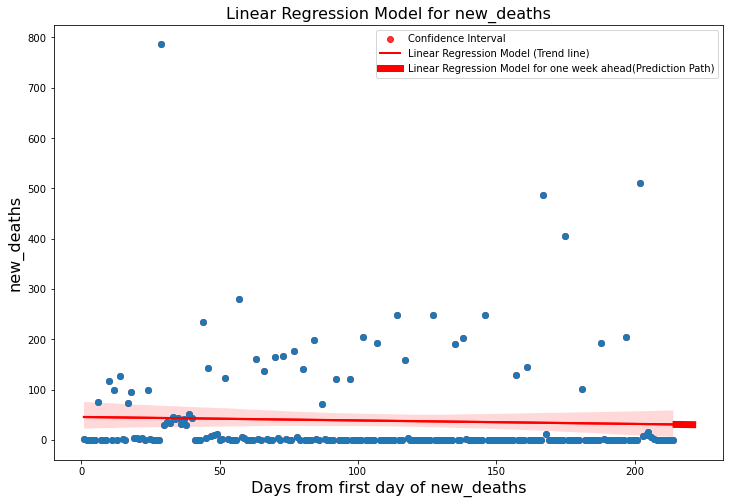

RMSE of Linear Regression on new_deaths 95.21051925043596


In [16]:
X_deaths,y_deaths = lr_model(selected_state_deaths,'first_day','new_deaths')

Non Linear Regression Model for the new_deaths across the CA State for degrees from 2 to 5

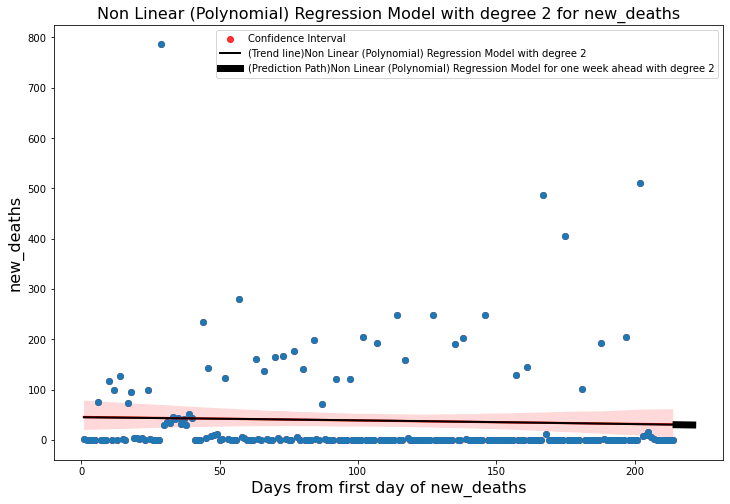

One week ahead forecast using Non-linear Regression Model with degree 2 [[30.03442521]
 [29.94987296]
 [29.86517734]
 [29.78033833]
 [29.69535594]
 [29.61023017]
 [29.52496102]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_deaths 95.21020480366471


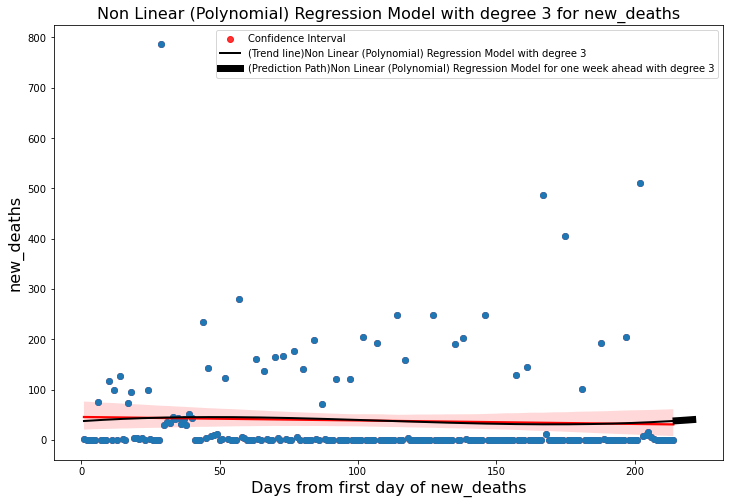

One week ahead forecast using Non-linear Regression Model with degree 3 [[37.89312386]
 [38.24719666]
 [38.61127943]
 [38.98546576]
 [39.36984922]
 [39.7645234 ]
 [40.16958187]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_deaths 95.166388508328


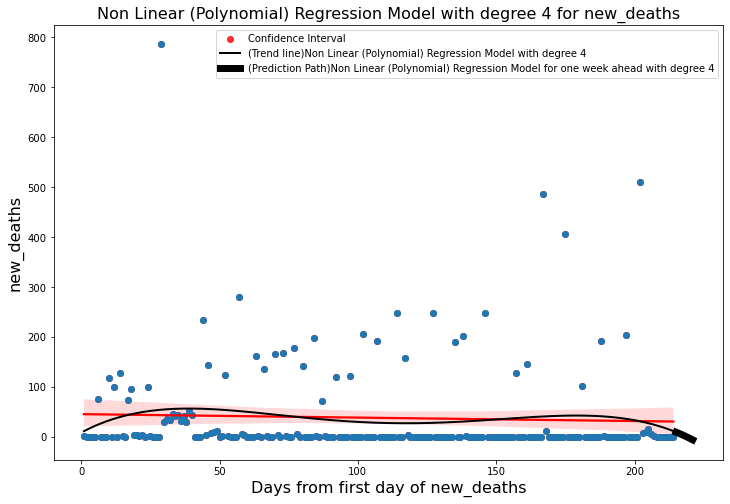

One week ahead forecast using Non-linear Regression Model with degree 4 [[ 9.35042414]
 [ 7.04936213]
 [ 4.64767947]
 [ 2.1430906 ]
 [-0.46671188]
 [-3.18405721]
 [-6.01129643]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_deaths 94.73224380387285


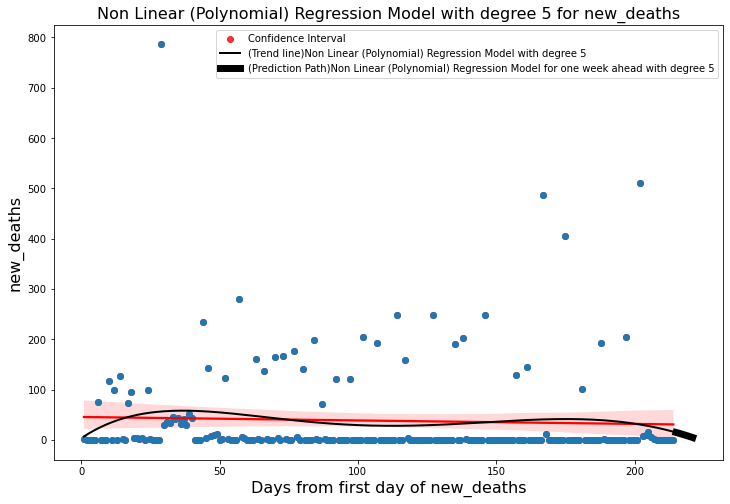

One week ahead forecast using Non-linear Regression Model with degree 5 [[14.66371375]
 [13.1040503 ]
 [11.49181993]
 [ 9.82650865]
 [ 8.1076172 ]
 [ 6.33466138]
 [ 4.50717241]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_deaths 94.72046886108102


In [17]:
non_lr_model(X_deaths,y_deaths,[2,3,4,5],'new_deaths')

Reading the daily county level data of the CA State csv file generated in the stage 2

In [18]:
selected_state_county_data_daily = pd.read_csv('../../../../data/Stage_2/selected_state_county_data_daily.csv')
selected_state_county_data_daily

,countyFIPS,County Name,State,StateFIPS,Dates,cases,deaths,population,new_cases,new_deaths
0,6001,Alameda County,CA,6,2022-05-30,284672,1870,1671329,658.0,7.0
1,6001,Alameda County,CA,6,2022-05-31,285051,1870,1671329,379.0,0.0
2,6001,Alameda County,CA,6,2022-06-01,285709,1870,1671329,658.0,0.0
3,6001,Alameda County,CA,6,2022-06-02,285819,1870,1671329,110.0,0.0
4,6001,Alameda County,CA,6,2022-06-03,285819,1870,1671329,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
12639,6115,Yuba County,CA,6,2022-12-29,19650,121,78668,0.0,0.0
12640,6115,Yuba County,CA,6,2022-12-30,19650,121,78668,0.0,0.0
12641,6115,Yuba County,CA,6,2022-12-31,19650,121,78668,0.0,0.0
12642,6115,Yuba County,CA,6,2023-01-01,19650,121,78668,0.0,0.0


In [19]:
#Converting the dates column into datetime
selected_state_county_data_daily['Dates'] = pd.to_datetime(selected_state_county_data_daily['Dates'])
selected_state_county_data_daily

,countyFIPS,County Name,State,StateFIPS,Dates,cases,deaths,population,new_cases,new_deaths
0,6001,Alameda County,CA,6,2022-05-30,284672,1870,1671329,658.0,7.0
1,6001,Alameda County,CA,6,2022-05-31,285051,1870,1671329,379.0,0.0
2,6001,Alameda County,CA,6,2022-06-01,285709,1870,1671329,658.0,0.0
3,6001,Alameda County,CA,6,2022-06-02,285819,1870,1671329,110.0,0.0
4,6001,Alameda County,CA,6,2022-06-03,285819,1870,1671329,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
12639,6115,Yuba County,CA,6,2022-12-29,19650,121,78668,0.0,0.0
12640,6115,Yuba County,CA,6,2022-12-30,19650,121,78668,0.0,0.0
12641,6115,Yuba County,CA,6,2022-12-31,19650,121,78668,0.0,0.0
12642,6115,Yuba County,CA,6,2023-01-01,19650,121,78668,0.0,0.0


In [20]:
#Removing the rows on the selected dates
selected_state_county_data_daily = selected_state_county_data_daily[~selected_state_county_data_daily.Dates.isin(['2022-05-30','2022-05-31','2023-01-01','2023-01-02'])]
selected_state_county_data_daily= selected_state_county_data_daily.reset_index(drop= True)
selected_state_county_data_daily

,countyFIPS,County Name,State,StateFIPS,Dates,cases,deaths,population,new_cases,new_deaths
0,6001,Alameda County,CA,6,2022-06-01,285709,1870,1671329,658.0,0.0
1,6001,Alameda County,CA,6,2022-06-02,285819,1870,1671329,110.0,0.0
2,6001,Alameda County,CA,6,2022-06-03,285819,1870,1671329,0.0,0.0
3,6001,Alameda County,CA,6,2022-06-04,285819,1870,1671329,0.0,0.0
4,6001,Alameda County,CA,6,2022-06-05,285819,1870,1671329,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
12407,6115,Yuba County,CA,6,2022-12-27,19650,121,78668,7.0,0.0
12408,6115,Yuba County,CA,6,2022-12-28,19650,121,78668,0.0,0.0
12409,6115,Yuba County,CA,6,2022-12-29,19650,121,78668,0.0,0.0
12410,6115,Yuba County,CA,6,2022-12-30,19650,121,78668,0.0,0.0


In [21]:
selected_state_county_data_daily1 = selected_state_county_data_daily.groupby(['countyFIPS','County Name','StateFIPS','population']).sum().reset_index()
selected_state_county_data_daily1.head()


,countyFIPS,County Name,StateFIPS,population,cases,deaths,new_cases,new_deaths
0,6001,Alameda County,6,1671329,72282454,426201,82896.0,222.0
1,6003,Alpine County,6,1129,28563,0,10.0,0.0
2,6005,Amador County,6,39752,2094773,19472,1495.0,9.0
3,6007,Butte County,6,219186,8240455,96739,6913.0,46.0
4,6009,Calaveras County,6,45905,1784428,28078,1304.0,14.0


Finding the top 5 infected counties across the CA State

In [22]:
selected_state_county_data_daily2 = selected_state_county_data_daily1.sort_values(['new_cases'],ascending = False)
selected_state_county_data_daily2.head(5)

,countyFIPS,County Name,StateFIPS,population,cases,deaths,new_cases,new_deaths
18,6037,Los Angeles County,6,10039107,685420148,7083040,576726.0,2461.0
36,6073,San Diego County,6,3338330,193002028,1171012,169096.0,338.0
29,6059,Orange County,6,3175692,139335973,1576808,120667.0,618.0
35,6071,San Bernardino County,6,2180085,139636983,1707439,114782.0,492.0
42,6085,Santa Clara County,6,1927852,89858008,523756,111182.0,267.0


In [23]:
la_county = selected_state_county_data_daily[selected_state_county_data_daily['countyFIPS']==6037]
la_county

,countyFIPS,County Name,State,StateFIPS,Dates,cases,deaths,population,new_cases,new_deaths
3852,6037,Los Angeles County,CA,6,2022-06-01,2846542,31896,10039107,3149.0,1.0
3853,6037,Los Angeles County,CA,6,2022-06-02,2846726,31896,10039107,184.0,0.0
3854,6037,Los Angeles County,CA,6,2022-06-03,2846726,31896,10039107,0.0,0.0
3855,6037,Los Angeles County,CA,6,2022-06-04,2846726,31896,10039107,0.0,0.0
3856,6037,Los Angeles County,CA,6,2022-06-05,2846726,31896,10039107,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4061,6037,Los Angeles County,CA,6,2022-12-27,3420119,34356,10039107,114.0,0.0
4062,6037,Los Angeles County,CA,6,2022-12-28,3420119,34356,10039107,0.0,0.0
4063,6037,Los Angeles County,CA,6,2022-12-29,3420119,34356,10039107,0.0,0.0
4064,6037,Los Angeles County,CA,6,2022-12-30,3420119,34356,10039107,0.0,0.0


In [24]:
la_county['new_cases'].clip(lower=0, inplace = True) 
la_county['new_deaths'].clip(lower=0, inplace = True)

In [25]:
la_new_cases_list = la_county['new_cases'].tolist()
la_new_deaths_list = la_county['new_deaths'].tolist()
la_ind_cases,la_first_day_cases = first_day_new_cases_deaths(la_new_cases_list)
la_county_cases = la_county[['Dates','new_cases']]
la_county_cases['first_day'] = la_first_day_cases
la_county_cases = la_county_cases.iloc[la_ind_cases:].reset_index(drop=True)
la_county_cases

,Dates,new_cases,first_day
0,2022-06-01,3149.0,1
1,2022-06-02,184.0,2
2,2022-06-03,0.0,3
3,2022-06-04,0.0,4
4,2022-06-05,0.0,5
...,...,...,...
209,2022-12-27,114.0,210
210,2022-12-28,0.0,211
211,2022-12-29,0.0,212
212,2022-12-30,0.0,213


Linear Regression Model for the new_cases across the Los Angeles County in the CA State

One week ahead forecast using Linear Regression Model = [[850.37527972]
 [832.01085067]
 [813.64642163]
 [795.28199259]
 [776.91756354]
 [758.5531345 ]
 [740.18870546]]


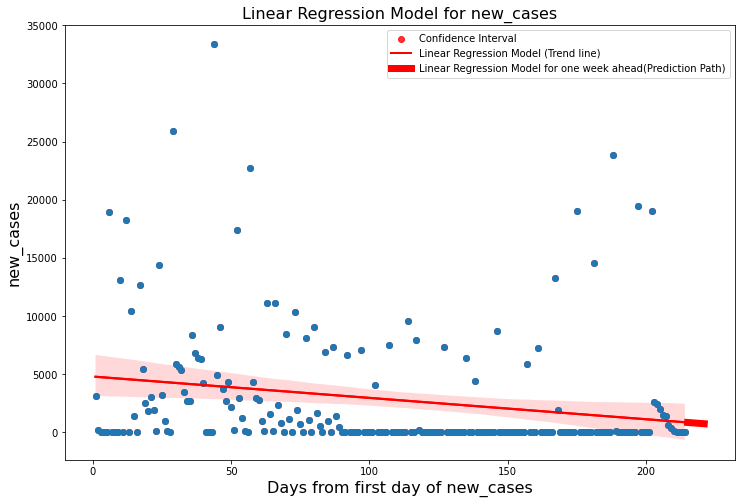

RMSE of Linear Regression on new_cases 5271.07127525108


In [26]:
la_X_cases,la_y_cases = lr_model(la_county_cases,'first_day','new_cases')

Polynomial Regression Model for the new_cases across the Los Angeles County in the CA State for the degrees from 2 to 5.

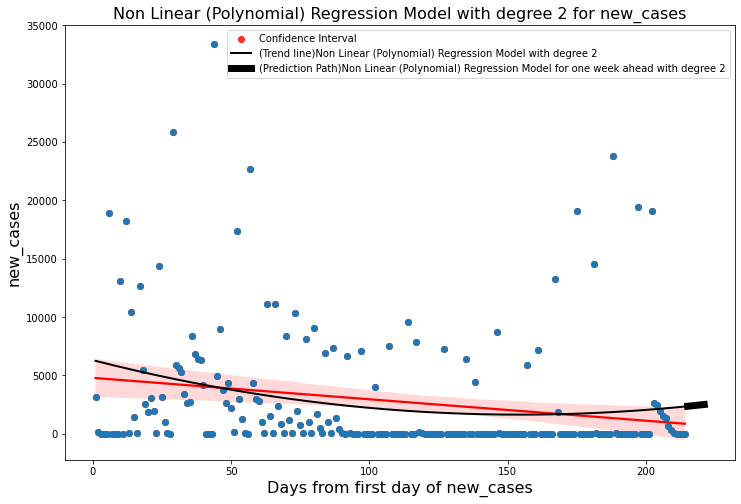

One week ahead forecast using Non-linear Regression Model with degree 2 [[2365.86924953]
 [2389.79767546]
 [2414.1177019 ]
 [2438.82932884]
 [2463.9325563 ]
 [2489.42738426]
 [2515.31381273]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_cases 5228.532128041434


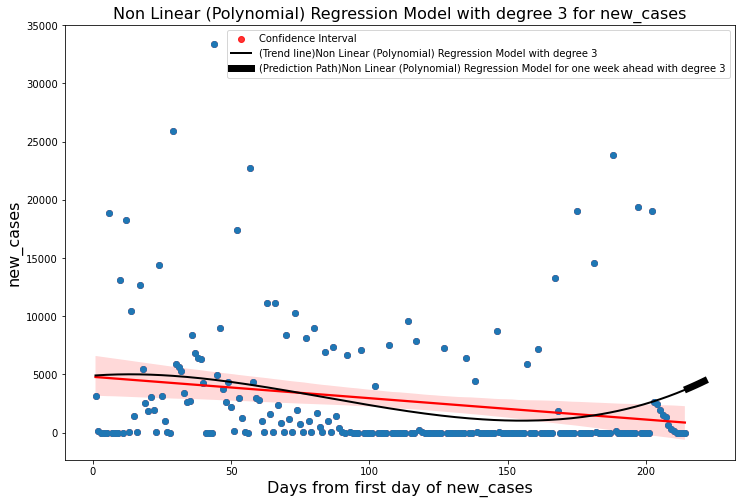

One week ahead forecast using Non-linear Regression Model with degree 3 [[3781.12124815]
 [3884.0404833 ]
 [3989.17980992]
 [4096.55608045]
 [4206.18614735]
 [4318.08686306]
 [4432.27508004]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_cases 5202.5972532096675


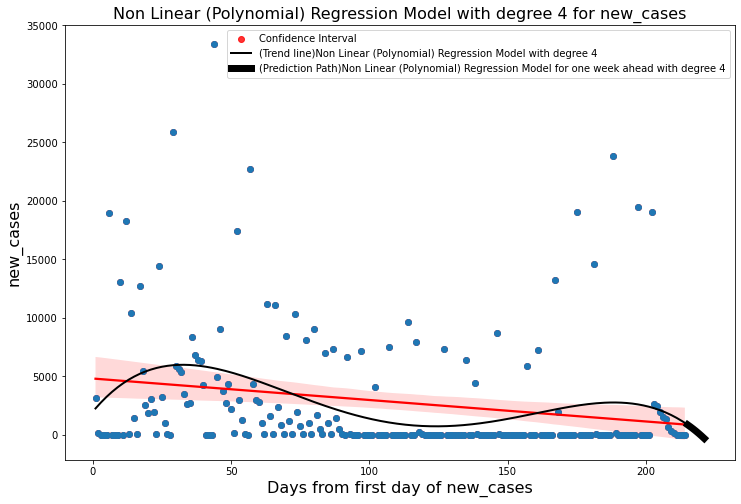

One week ahead forecast using Non-linear Regression Model with degree 4 [[ 842.51242768]
 [ 672.07270702]
 [ 492.46312137]
 [ 303.45557787]
 [ 104.81973647]
 [-103.67699009]
 [-322.26943626]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_cases 5117.923621133982


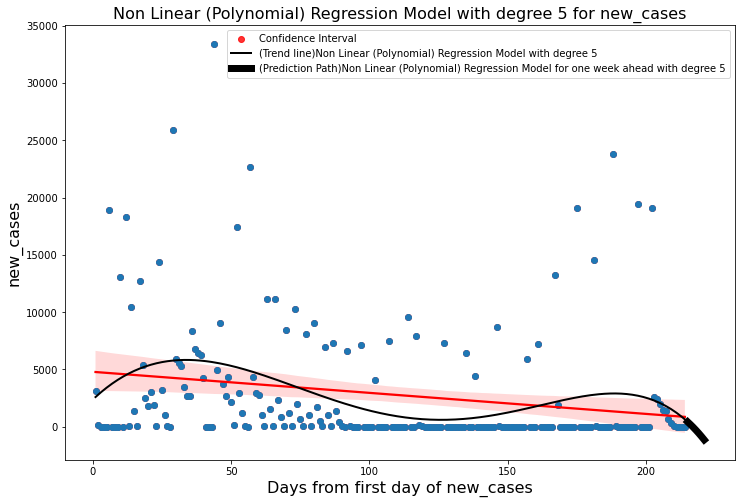

One week ahead forecast using Non-linear Regression Model with degree 5 [[  432.2347587 ]
 [  204.547207  ]
 [  -36.0207139 ]
 [ -289.83388958]
 [ -557.26227658]
 [ -838.68092809]
 [-1134.47001981]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_cases 5116.6240488058465


In [27]:
non_lr_model(la_X_cases,la_y_cases,[2,3,4,5],'new_cases')

In [28]:
la_ind_deaths,la_first_day_deaths = first_day_new_cases_deaths(la_new_deaths_list)
la_county_deaths = la_county[['Dates','new_deaths']]
la_county_deaths['first_day'] = la_first_day_deaths
la_county_deaths = la_county_deaths.iloc[la_ind_deaths:].reset_index(drop=True)
la_county_deaths

,Dates,new_deaths,first_day
0,2022-06-01,1.0,1
1,2022-06-02,0.0,2
2,2022-06-03,0.0,3
3,2022-06-04,0.0,4
4,2022-06-05,0.0,5
...,...,...,...
209,2022-12-27,0.0,210
210,2022-12-28,0.0,211
211,2022-12-29,0.0,212
212,2022-12-30,0.0,213


Linear Regression Model for the new_deaths across the Los Angeles County in the CA State

One week ahead forecast using Linear Regression Model = [[13.48058444]
 [13.4879674 ]
 [13.49535037]
 [13.50273333]
 [13.51011629]
 [13.51749926]
 [13.52488222]]


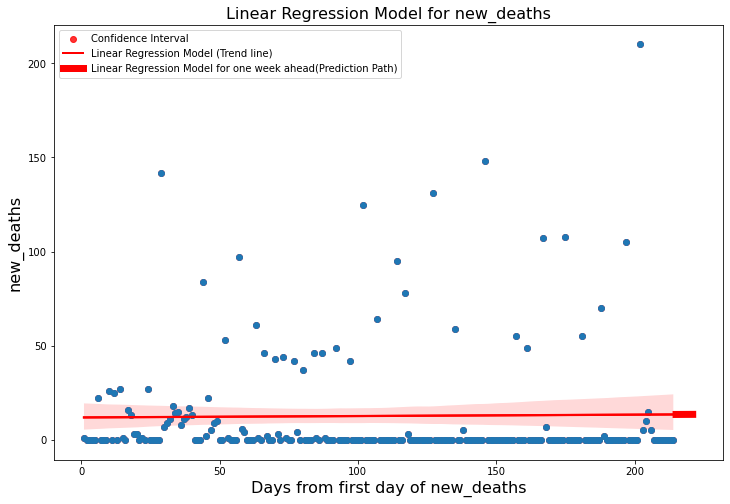

RMSE of Linear Regression on new_deaths 30.70659369260208


In [29]:
la_X_deaths,la_y_deaths = lr_model(la_county_deaths,'first_day','new_deaths')

Polynomial Regression Model for the new_deaths across the Los Angeles County in the CA State from degrees 2 to 5

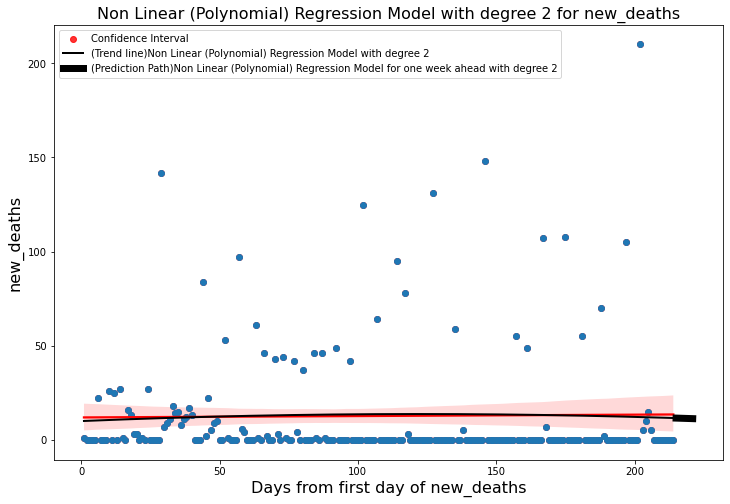

One week ahead forecast using Non-linear Regression Model with degree 2 [[11.54393989]
 [11.49727696]
 [11.4501136 ]
 [11.40244982]
 [11.35428561]
 [11.30562098]
 [11.25645593]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_deaths 30.694714813547375


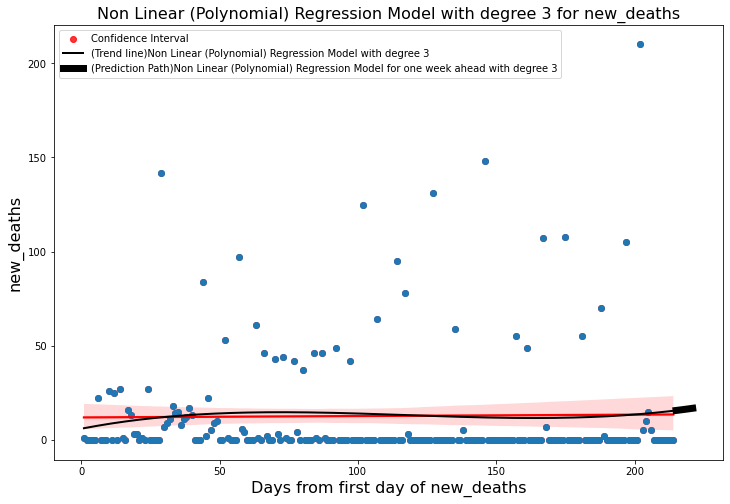

One week ahead forecast using Non-linear Regression Model with degree 3 [[15.60599554]
 [15.78605199]
 [15.97085615]
 [16.1604564 ]
 [16.35490109]
 [16.5542386 ]
 [16.75851729]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_deaths 30.65839002229418


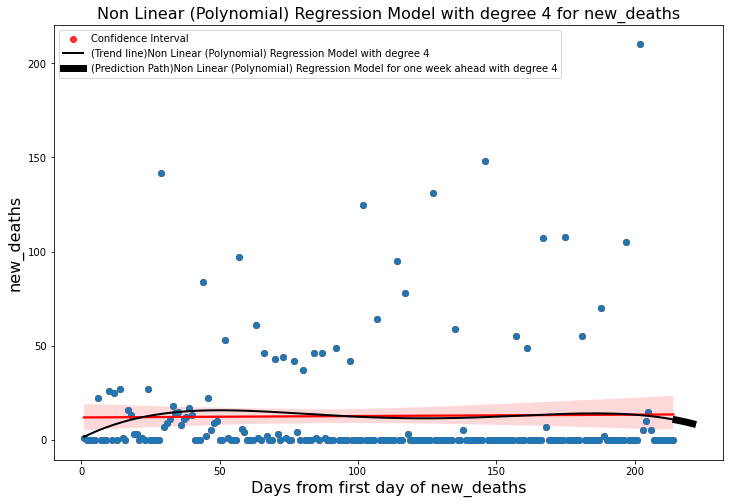

One week ahead forecast using Non-linear Regression Model with degree 4 [[10.54136432]
 [10.2502923 ]
 [ 9.94433763]
 [ 9.62312653]
 [ 9.28628133]
 [ 8.93342051]
 [ 8.56415865]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_deaths 30.616027411819587


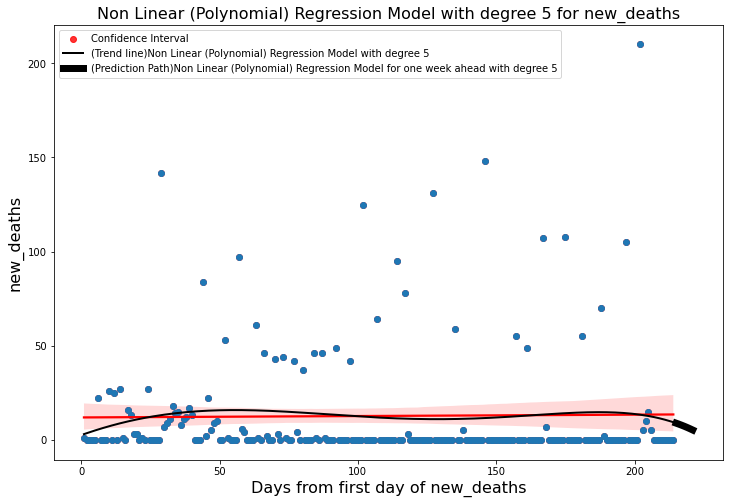

One week ahead forecast using Non-linear Regression Model with degree 5 [[8.8540787 ]
 [8.32757022]
 [7.77091932]
 [7.18318963]
 [6.5634293 ]
 [5.9106709 ]
 [5.22393129]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_deaths 30.612353335120943


In [30]:
non_lr_model(la_X_deaths,la_y_deaths,[2,3,4,5],'new_deaths')

In [31]:
sd_county = selected_state_county_data_daily[selected_state_county_data_daily['countyFIPS']==6073]
sd_county

,countyFIPS,County Name,State,StateFIPS,Dates,cases,deaths,population,new_cases,new_deaths
7704,6073,San Diego County,CA,6,2022-06-01,794606,5303,3338330,1101.0,0.0
7705,6073,San Diego County,CA,6,2022-06-02,794823,5303,3338330,217.0,0.0
7706,6073,San Diego County,CA,6,2022-06-03,794823,5303,3338330,0.0,0.0
7707,6073,San Diego County,CA,6,2022-06-04,794823,5303,3338330,0.0,0.0
7708,6073,San Diego County,CA,6,2022-06-05,794823,5303,3338330,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7913,6073,San Diego County,CA,6,2022-12-27,962601,5641,3338330,130.0,0.0
7914,6073,San Diego County,CA,6,2022-12-28,962601,5641,3338330,0.0,0.0
7915,6073,San Diego County,CA,6,2022-12-29,962601,5641,3338330,0.0,0.0
7916,6073,San Diego County,CA,6,2022-12-30,962601,5641,3338330,0.0,0.0


In [32]:
sd_county['new_cases'].clip(lower=0, inplace = True) 
sd_county['new_deaths'].clip(lower=0, inplace = True)

In [33]:
sd_new_cases_list = sd_county['new_cases'].tolist()
sd_new_deaths_list = sd_county['new_deaths'].tolist()
sd_ind_cases,sd_first_day_cases = first_day_new_cases_deaths(sd_new_cases_list)
sd_county_cases = sd_county[['Dates','new_cases']]
sd_county_cases['first_day'] = sd_first_day_cases
sd_county_cases = sd_county_cases.iloc[sd_ind_cases:].reset_index(drop=True)
sd_county_cases

,Dates,new_cases,first_day
0,2022-06-01,1101.0,1
1,2022-06-02,217.0,2
2,2022-06-03,0.0,3
3,2022-06-04,0.0,4
4,2022-06-05,0.0,5
...,...,...,...
209,2022-12-27,130.0,210
210,2022-12-28,0.0,211
211,2022-12-29,0.0,212
212,2022-12-30,0.0,213


Linear Regression Model for the new_cases across the San Diego County in the CA State

One week ahead forecast using Linear Regression Model = [[149.89100961]
 [143.78001965]
 [137.6690297 ]
 [131.55803974]
 [125.44704978]
 [119.33605983]
 [113.22506987]]


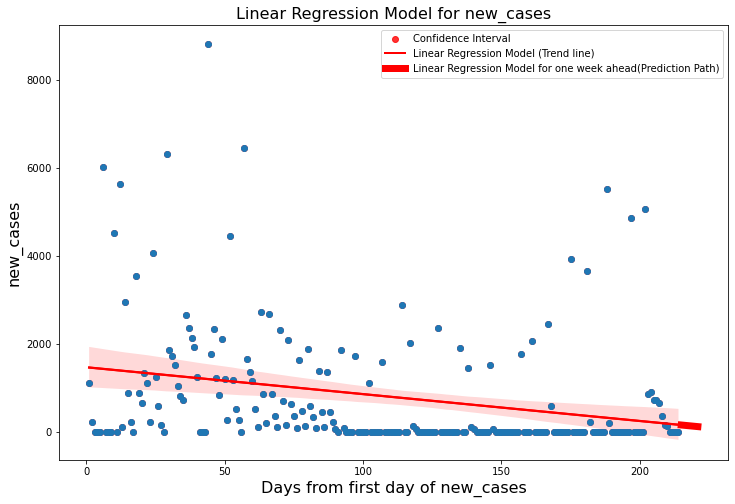

RMSE of Linear Regression on new_cases 1368.5251676646126


In [34]:
sd_X_cases,sd_y_cases = lr_model(sd_county_cases,'first_day','new_cases')

Polynomial Regression Model for the new_cases across the San Diego County in the CA State from degrees 2 to 5

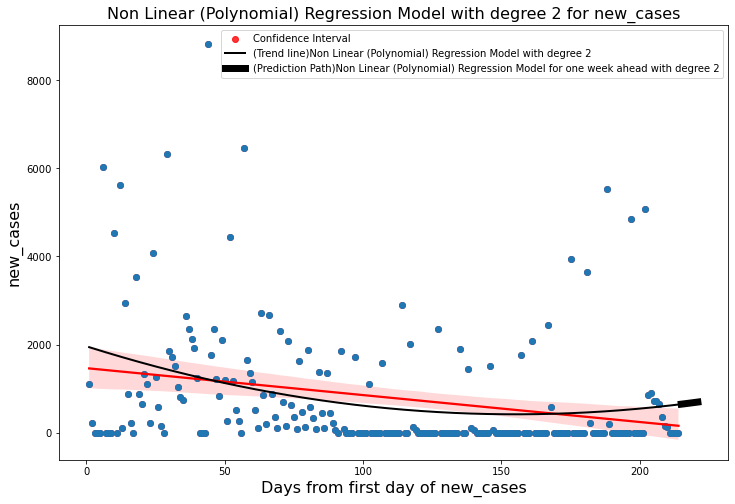

One week ahead forecast using Non-linear Regression Model with degree 2 [[646.32638877]
 [654.06940939]
 [661.94070789]
 [669.94028427]
 [678.06813852]
 [686.32427065]
 [694.70868065]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_cases 1350.901293677395


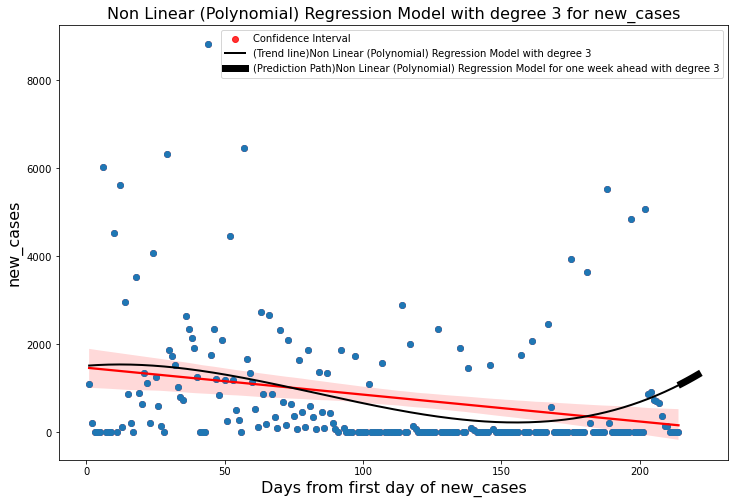

One week ahead forecast using Non-linear Regression Model with degree 3 [[1098.35516994]
 [1131.32770394]
 [1165.01253232]
 [1199.41503773]
 [1234.54060281]
 [1270.3946102 ]
 [1306.98244255]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_cases 1340.6476593059447


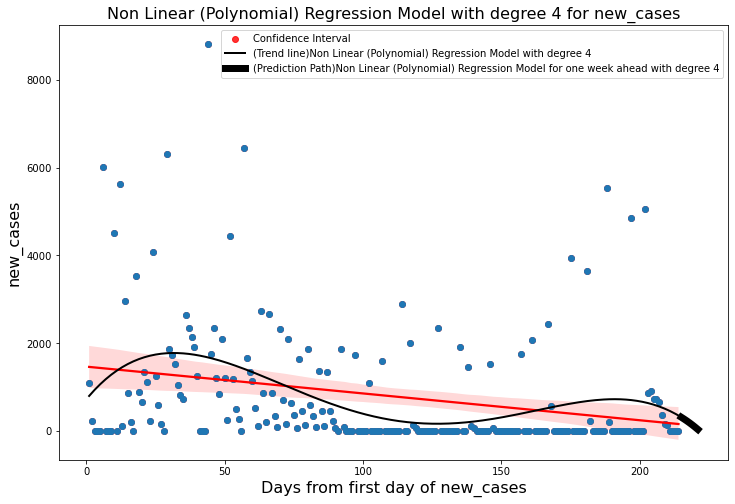

One week ahead forecast using Non-linear Regression Model with degree 4 [[310.41151914]
 [270.08696982]
 [227.42066976]
 [182.3523232 ]
 [134.82103184]
 [ 84.76529483]
 [ 32.12300874]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_cases 1317.0070851491319


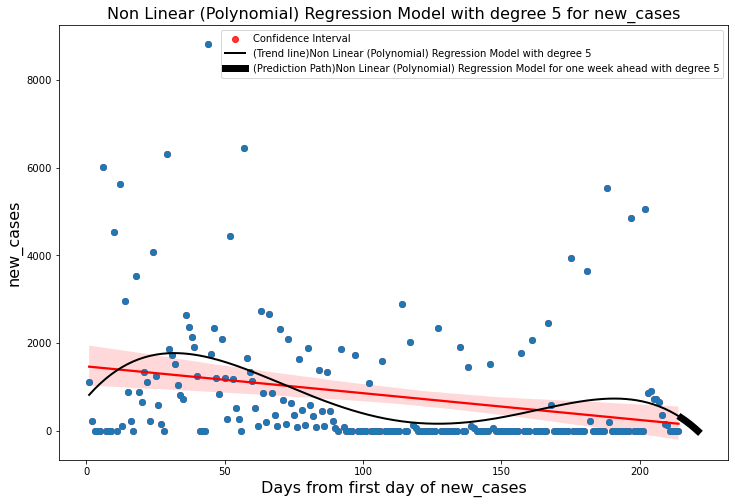

One week ahead forecast using Non-linear Regression Model with degree 5 [[289.12188788]
 [245.82762903]
 [199.99914944]
 [151.56905777]
 [100.4692137 ]
 [ 46.63072652]
 [-10.01604615]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_cases 1316.9934991982134


In [35]:
non_lr_model(sd_X_cases,sd_y_cases,[2,3,4,5],'new_cases')

In [36]:
sd_ind_deaths,sd_first_day_deaths = first_day_new_cases_deaths(sd_new_deaths_list)
sd_county_deaths = sd_county[['Dates','new_deaths']]
sd_county_deaths['first_day'] = sd_first_day_deaths
sd_county_deaths = sd_county_deaths.iloc[sd_ind_deaths:].reset_index(drop=True)
sd_county_deaths

,Dates,new_deaths,first_day
0,2022-06-06,5.0,1
1,2022-06-07,0.0,2
2,2022-06-08,0.0,3
3,2022-06-09,0.0,4
4,2022-06-10,7.0,5
...,...,...,...
204,2022-12-27,0.0,205
205,2022-12-28,0.0,206
206,2022-12-29,0.0,207
207,2022-12-30,0.0,208


Linear Regression Model for the new_deaths across the San Diego County in the CA State.

One week ahead forecast using Linear Regression Model = [[1.80939455]
 [1.8083995 ]
 [1.80740444]
 [1.80640938]
 [1.80541432]
 [1.80441926]
 [1.80342421]]


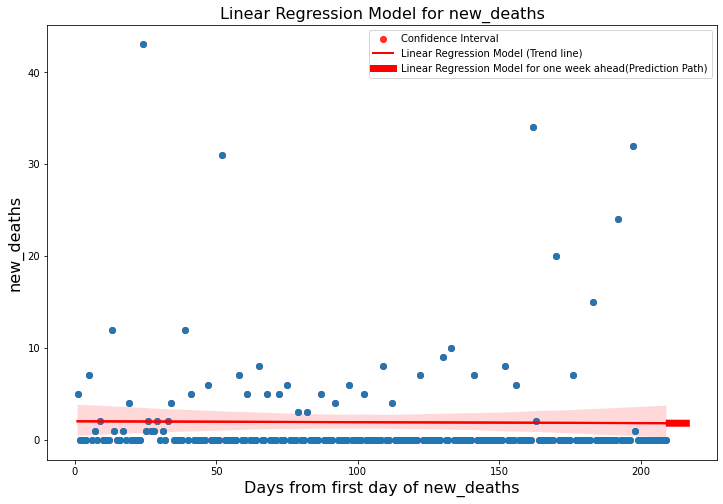

RMSE of Linear Regression on new_deaths 5.68709464181719


In [37]:
sd_X_deaths,sd_y_deaths = lr_model(sd_county_deaths,'first_day','new_deaths')

Polynomial Regression Model for the new_deaths across the San Diego County in the CA State for the degrees 2 to 5

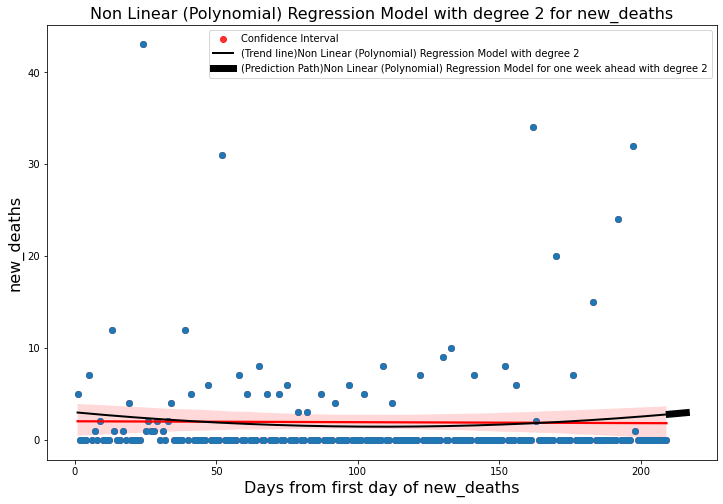

One week ahead forecast using Non-linear Regression Model with degree 2 [[2.78758541]
 [2.81453866]
 [2.84175683]
 [2.86923991]
 [2.8969879 ]
 [2.9250008 ]
 [2.95327862]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_deaths 5.670722169417672


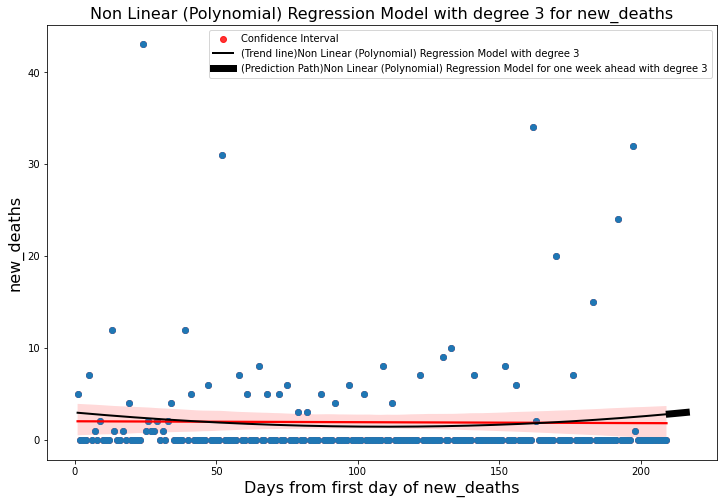

One week ahead forecast using Non-linear Regression Model with degree 3 [[2.81032605]
 [2.83857876]
 [2.86712719]
 [2.89597161]
 [2.92511231]
 [2.9545496 ]
 [2.98428375]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_deaths 5.67071601903339


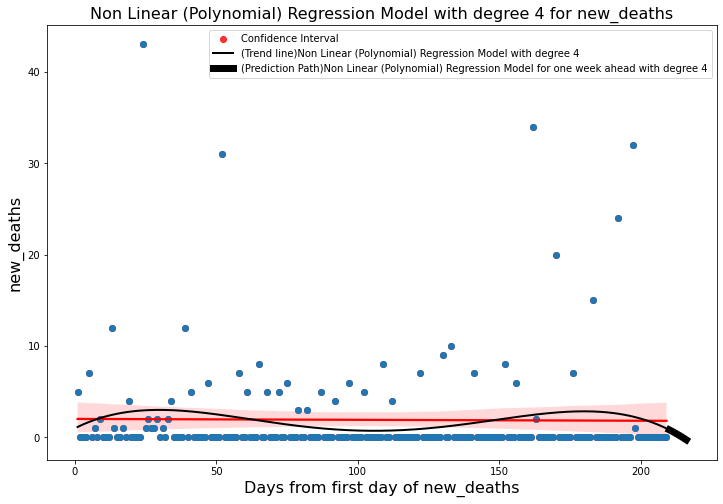

One week ahead forecast using Non-linear Regression Model with degree 4 [[ 0.8186781 ]
 [ 0.65725006]
 [ 0.48802708]
 [ 0.31083135]
 [ 0.12548339]
 [-0.06819794]
 [-0.27039547]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_deaths 5.635290930881534


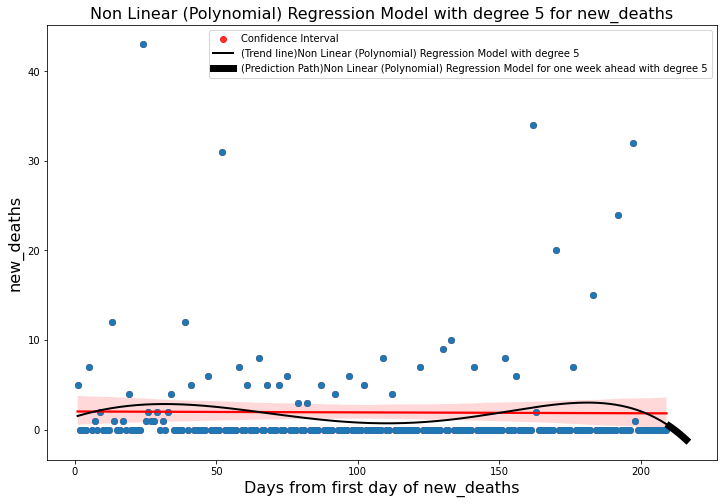

One week ahead forecast using Non-linear Regression Model with degree 5 [[ 0.381953  ]
 [ 0.15813564]
 [-0.07761624]
 [-0.32563665]
 [-0.58626459]
 [-0.85984404]
 [-1.14672404]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_deaths 5.633958072793067


In [38]:
non_lr_model(sd_X_deaths,sd_y_deaths,[2,3,4,5],'new_deaths')

In [39]:
o_county = selected_state_county_data_daily[selected_state_county_data_daily['countyFIPS']==6059]
o_county

,countyFIPS,County Name,State,StateFIPS,Dates,cases,deaths,population,new_cases,new_deaths
6206,6059,Orange County,CA,6,2022-06-01,574082,7038,3175692,670.0,0.0
6207,6059,Orange County,CA,6,2022-06-02,574233,7038,3175692,151.0,0.0
6208,6059,Orange County,CA,6,2022-06-03,574233,7038,3175692,0.0,0.0
6209,6059,Orange County,CA,6,2022-06-04,574233,7038,3175692,0.0,0.0
6210,6059,Orange County,CA,6,2022-06-05,574233,7038,3175692,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
6415,6059,Orange County,CA,6,2022-12-27,694079,7656,3175692,155.0,0.0
6416,6059,Orange County,CA,6,2022-12-28,694079,7656,3175692,0.0,0.0
6417,6059,Orange County,CA,6,2022-12-29,694079,7656,3175692,0.0,0.0
6418,6059,Orange County,CA,6,2022-12-30,694079,7656,3175692,0.0,0.0


In [40]:
o_county['new_cases'].clip(lower=0, inplace = True) 
o_county['new_deaths'].clip(lower=0, inplace = True)

In [41]:
o_new_cases_list = o_county['new_cases'].tolist()
o_new_deaths_list = o_county['new_deaths'].tolist()
o_ind_cases,o_first_day_cases = first_day_new_cases_deaths(o_new_cases_list)
o_county_cases = o_county[['Dates','new_cases']]
o_county_cases['first_day'] = o_first_day_cases
o_county_cases = o_county_cases.iloc[o_ind_cases:].reset_index(drop=True)
o_county_cases

,Dates,new_cases,first_day
0,2022-06-01,670.0,1
1,2022-06-02,151.0,2
2,2022-06-03,0.0,3
3,2022-06-04,0.0,4
4,2022-06-05,0.0,5
...,...,...,...
209,2022-12-27,155.0,210
210,2022-12-28,0.0,211
211,2022-12-29,0.0,212
212,2022-12-30,0.0,213


Linear Regression Model for the new_cases across the Orange County in the CA State.

One week ahead forecast using Linear Regression Model = [[95.82414111]
 [91.39824962]
 [86.97235812]
 [82.54646663]
 [78.12057514]
 [73.69468364]
 [69.26879215]]


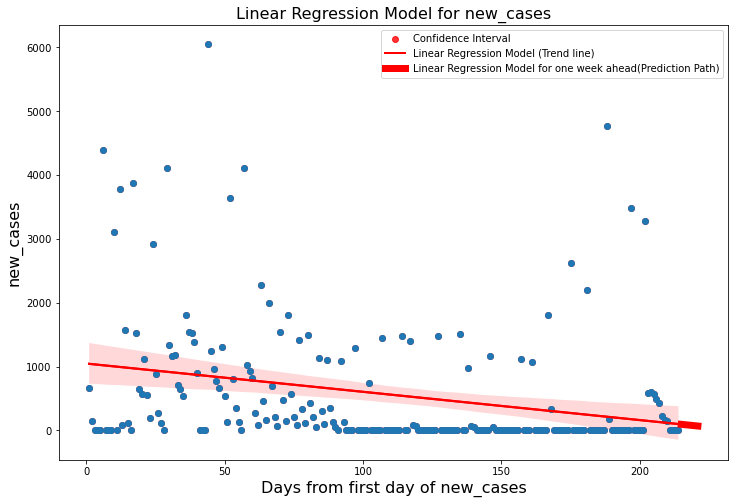

RMSE of Linear Regression on new_cases 974.0624275998631


In [42]:
o_X_cases,o_y_cases = lr_model(o_county_cases,'first_day','new_cases')

Polynomial Regression Model for the new_cases across the Orange County in the CA State from degrees 2 to 5

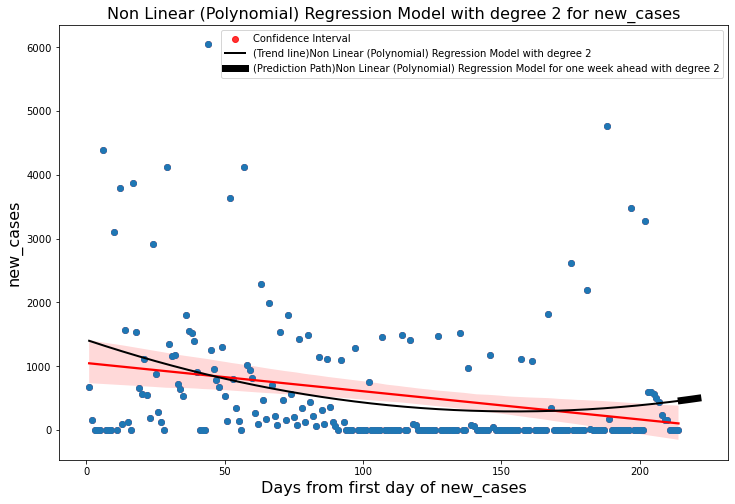

One week ahead forecast using Non-linear Regression Model with degree 2 [[459.0941695 ]
 [464.80604624]
 [470.6117912 ]
 [476.51140439]
 [482.50488581]
 [488.59223544]
 [494.77345331]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_cases 960.798792528969


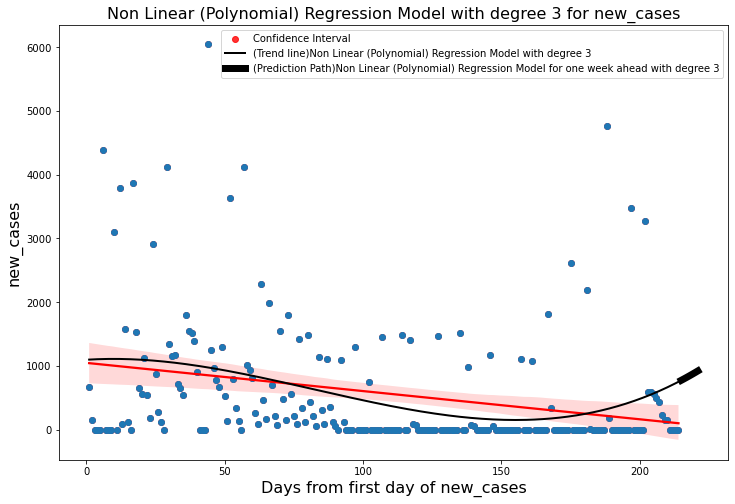

One week ahead forecast using Non-linear Regression Model with degree 3 [[773.73781434]
 [797.01119684]
 [820.7849639 ]
 [845.06286221]
 [869.84863848]
 [895.14603939]
 [920.95881164]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_cases 953.8147845144257


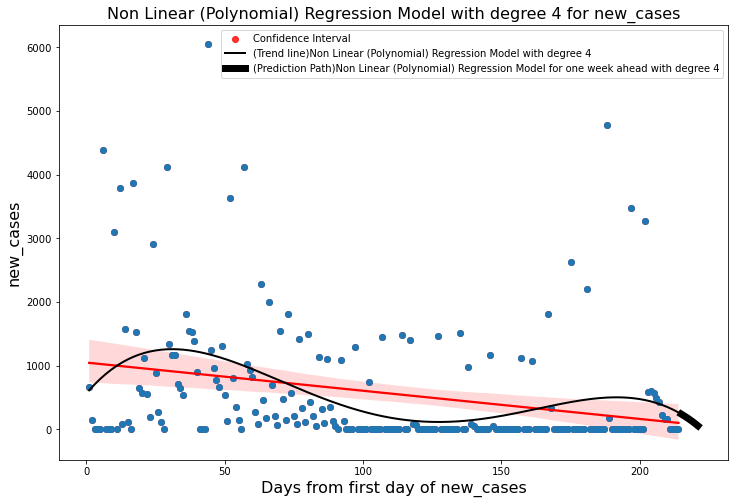

One week ahead forecast using Non-linear Regression Model with degree 4 [[238.47756059]
 [211.95929153]
 [183.86675487]
 [154.15908115]
 [122.79499156]
 [ 89.73279796]
 [ 54.93040292]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_cases 938.4931730536281


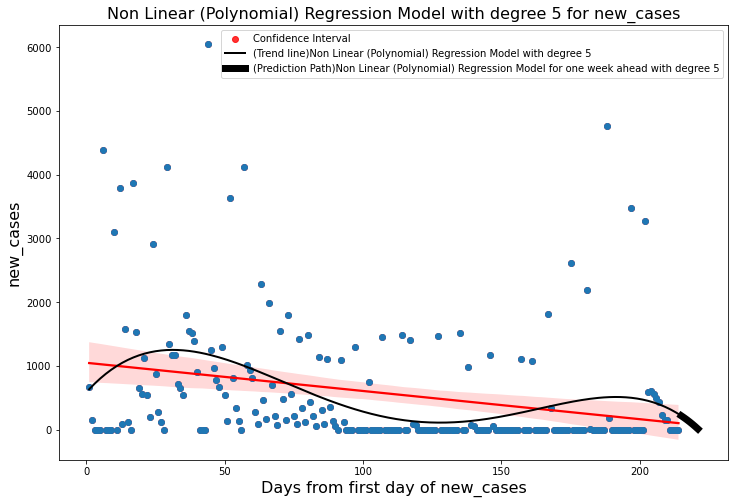

One week ahead forecast using Non-linear Regression Model with degree 5 [[215.43327449]
 [185.6998285 ]
 [154.18372756]
 [120.83641974]
 [ 85.60878519]
 [ 48.45113474]
 [  9.31320839]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_cases 938.4708227722707


In [43]:
non_lr_model(o_X_cases,o_y_cases,[2,3,4,5],'new_cases')

In [44]:
o_ind_deaths,o_first_day_deaths = first_day_new_cases_deaths(o_new_deaths_list)
o_county_deaths = o_county[['Dates','new_deaths']]
o_county_deaths['first_day'] = o_first_day_deaths
o_county_deaths = o_county_deaths.iloc[o_ind_deaths:].reset_index(drop=True)
o_county_deaths

,Dates,new_deaths,first_day
0,2022-06-06,5.0,1
1,2022-06-07,0.0,2
2,2022-06-08,0.0,3
3,2022-06-09,0.0,4
4,2022-06-10,13.0,5
...,...,...,...
204,2022-12-27,0.0,205
205,2022-12-28,0.0,206
206,2022-12-29,0.0,207
207,2022-12-30,0.0,208


Linear Regression Model for the new_deaths across the Orange County in the CA State.

One week ahead forecast using Linear Regression Model = [[2.62651822]
 [2.61776644]
 [2.60901467]
 [2.60026289]
 [2.59151112]
 [2.58275935]
 [2.57400757]]


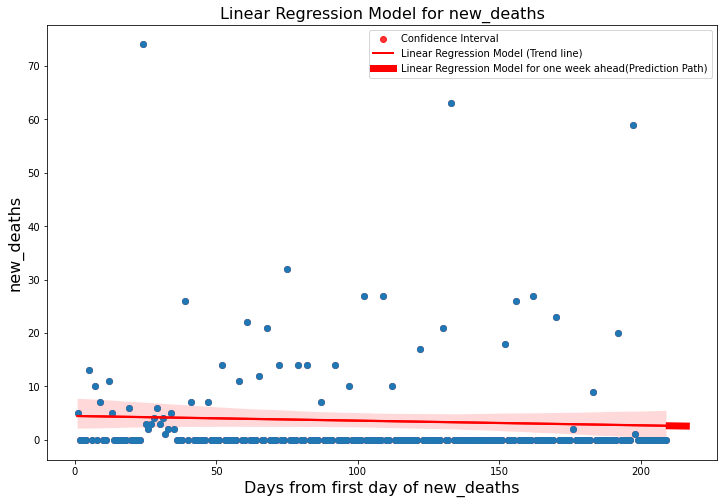

RMSE of Linear Regression on new_deaths 9.793941313108094


In [45]:
o_X_deaths,o_y_deaths = lr_model(o_county_deaths,'first_day','new_deaths')

Polynomial Regression Model for the new_deaths across the Orange County in the CA State from the degree 2 to 5

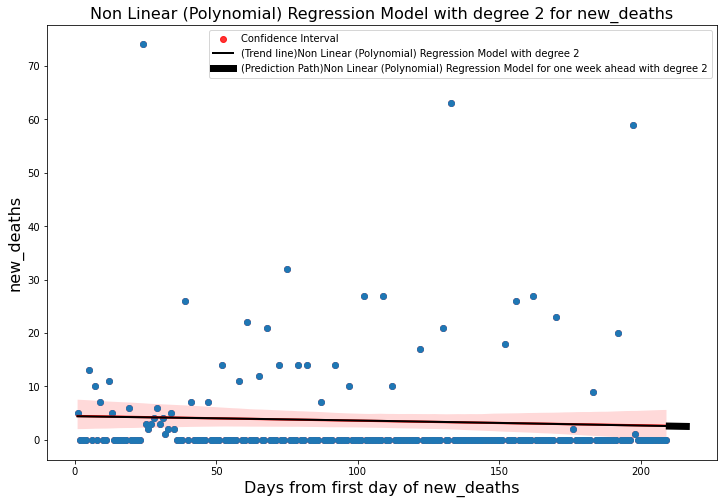

One week ahead forecast using Non-linear Regression Model with degree 2 [[2.57145696]
 [2.561132  ]
 [2.55079214]
 [2.54043736]
 [2.53006767]
 [2.51968307]
 [2.50928356]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_deaths 9.793911233828906


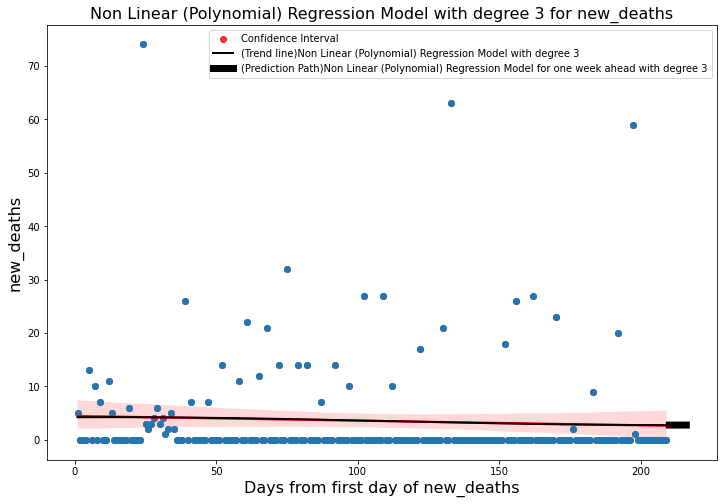

One week ahead forecast using Non-linear Regression Model with degree 3 [[2.75830294]
 [2.7586549 ]
 [2.75924496]
 [2.7600755 ]
 [2.76114891]
 [2.76246757]
 [2.76403388]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_deaths 9.793670824138557


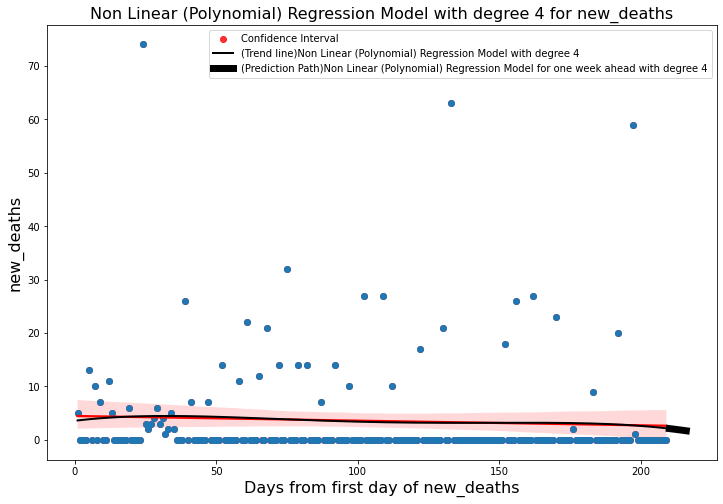

One week ahead forecast using Non-linear Regression Model with degree 4 [[2.10133029]
 [2.03911343]
 [1.97446585]
 [1.90733119]
 [1.83765255]
 [1.76537245]
 [1.69043288]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_deaths 9.791445652833998


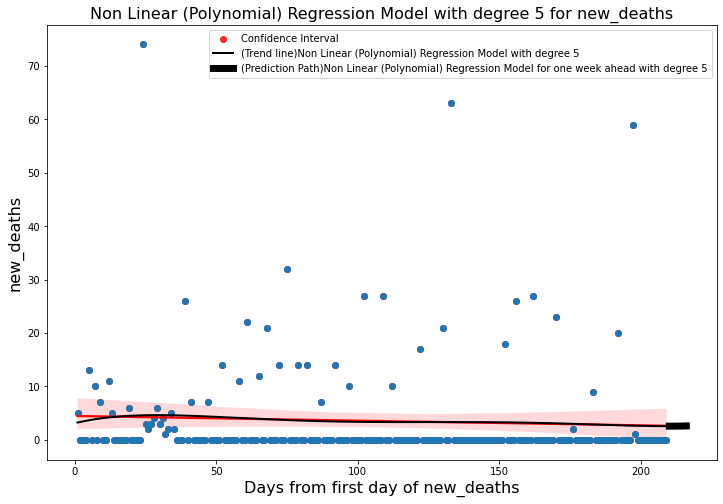

One week ahead forecast using Non-linear Regression Model with degree 5 [[2.55383492]
 [2.55626208]
 [2.56054771]
 [2.5667973 ]
 [2.57511922]
 [2.58562472]
 [2.598428  ]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_deaths 9.790622166170127


In [46]:
non_lr_model(o_X_deaths,o_y_deaths,[2,3,4,5],'new_deaths')

In [47]:
sb_county = selected_state_county_data_daily[selected_state_county_data_daily['countyFIPS']==6071]
sb_county

,countyFIPS,County Name,State,StateFIPS,Dates,cases,deaths,population,new_cases,new_deaths
7490,6071,San Bernardino County,CA,6,2022-06-01,582263,7611,2180085,630.0,0.0
7491,6071,San Bernardino County,CA,6,2022-06-02,582354,7611,2180085,91.0,0.0
7492,6071,San Bernardino County,CA,6,2022-06-03,582354,7611,2180085,0.0,0.0
7493,6071,San Bernardino County,CA,6,2022-06-04,582354,7611,2180085,0.0,0.0
7494,6071,San Bernardino County,CA,6,2022-06-05,582354,7611,2180085,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7699,6071,San Bernardino County,CA,6,2022-12-27,696415,8103,2180085,63.0,0.0
7700,6071,San Bernardino County,CA,6,2022-12-28,696415,8103,2180085,0.0,0.0
7701,6071,San Bernardino County,CA,6,2022-12-29,696415,8103,2180085,0.0,0.0
7702,6071,San Bernardino County,CA,6,2022-12-30,696415,8103,2180085,0.0,0.0


In [48]:
sb_county['new_cases'].clip(lower=0, inplace = True) 
sb_county['new_deaths'].clip(lower=0, inplace = True)

In [49]:
sb_new_cases_list = sb_county['new_cases'].tolist()
sb_new_deaths_list = sb_county['new_deaths'].tolist()
sb_ind_cases,sb_first_day_cases = first_day_new_cases_deaths(sb_new_cases_list)
sb_county_cases = sb_county[['Dates','new_cases']]
sb_county_cases['first_day'] = sb_first_day_cases
sb_county_cases = sb_county_cases.iloc[sb_ind_cases:].reset_index(drop=True)
sb_county_cases

,Dates,new_cases,first_day
0,2022-06-01,630.0,1
1,2022-06-02,91.0,2
2,2022-06-03,0.0,3
3,2022-06-04,0.0,4
4,2022-06-05,0.0,5
...,...,...,...
209,2022-12-27,63.0,210
210,2022-12-28,0.0,211
211,2022-12-29,0.0,212
212,2022-12-30,0.0,213


Linear Regression Model for the new_cases across the San Bernardino County in the CA State.

One week ahead forecast using Linear Regression Model = [[175.42253521]
 [171.80738296]
 [168.19223072]
 [164.57707847]
 [160.96192622]
 [157.34677397]
 [153.73162172]]


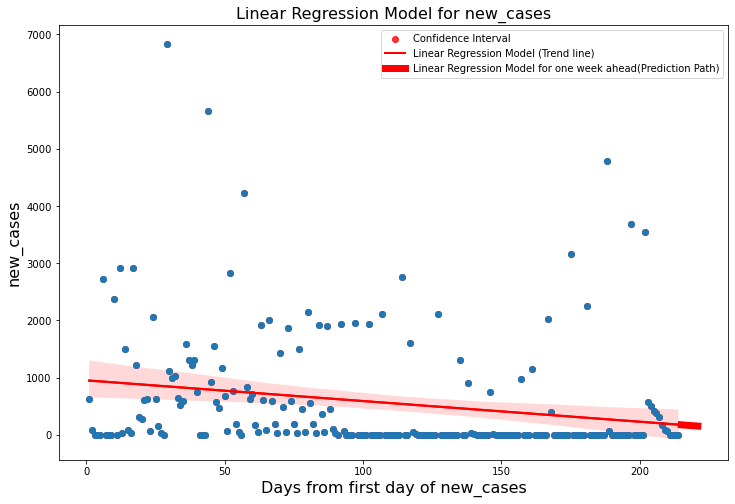

RMSE of Linear Regression on new_cases 1015.7171448680534


In [50]:
sb_X_cases,sb_y_cases = lr_model(sb_county_cases,'first_day','new_cases')

Polynomial Regression Model for the new_cases across the San Bernardino County in the CA State for the degrees 2 to 5

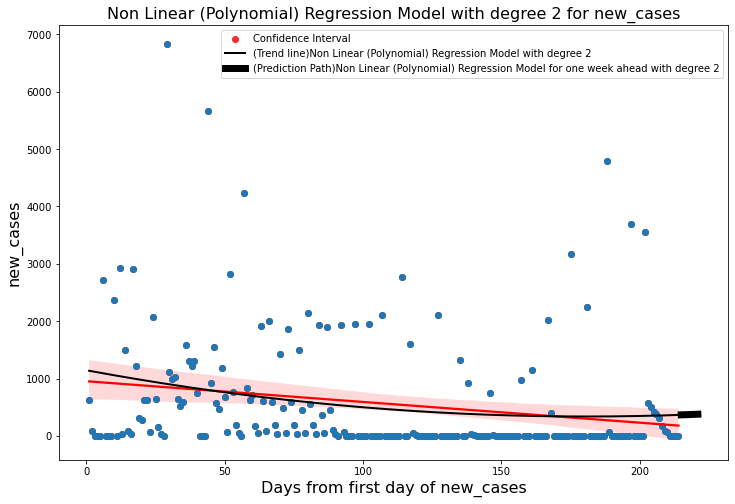

One week ahead forecast using Non-linear Regression Model with degree 2 [[366.45874985]
 [368.17484081]
 [369.94029512]
 [371.7551128 ]
 [373.61929384]
 [375.53283824]
 [377.49574601]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_cases 1012.2174457022201


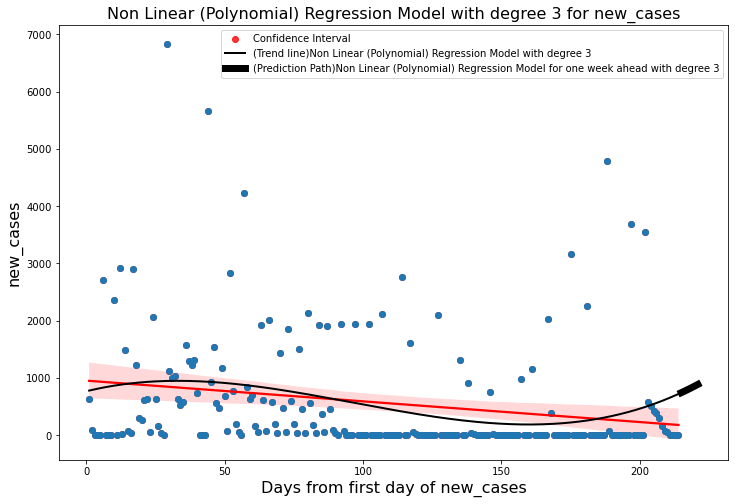

One week ahead forecast using Non-linear Regression Model with degree 3 [[742.61979113]
 [765.33091695]
 [788.5774023 ]
 [812.36372642]
 [836.69436854]
 [861.57380788]
 [887.00652367]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_cases 1002.7325778639913


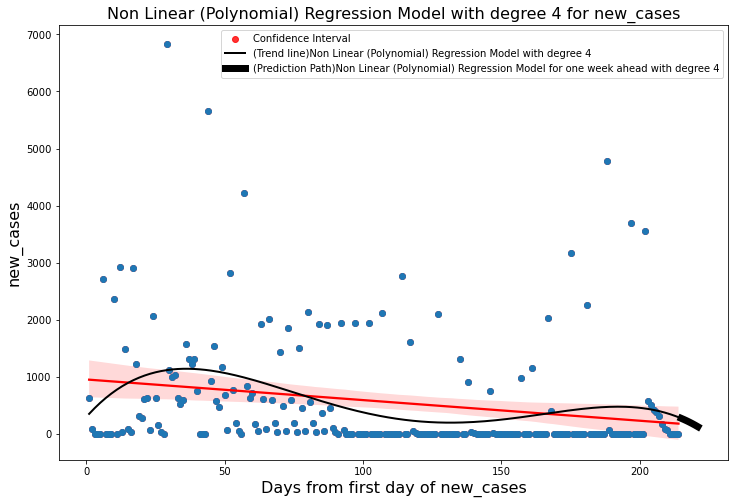

One week ahead forecast using Non-linear Regression Model with degree 4 [[271.2589772 ]
 [250.12258506]
 [227.69457253]
 [203.94012896]
 [178.82408323]
 [152.31090375]
 [124.3646985 ]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_cases 991.4578360755326


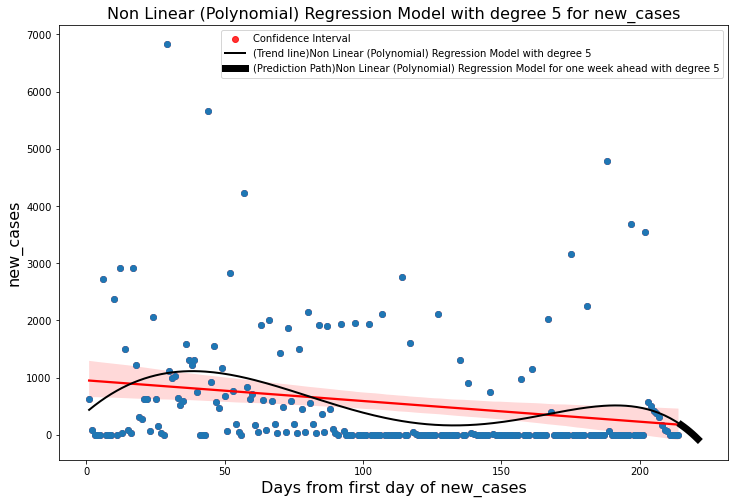

One week ahead forecast using Non-linear Regression Model with degree 5 [[171.02160505]
 [135.89878929]
 [ 98.57782801]
 [ 58.99049028]
 [ 17.06749486]
 [-27.26149613]
 [-74.0678835 ]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_cases 991.0573882918412


In [51]:
non_lr_model(sb_X_cases,sb_y_cases,[2,3,4,5],'new_cases')

In [52]:
sb_ind_deaths,sb_first_day_deaths = first_day_new_cases_deaths(sb_new_deaths_list)
sb_county_deaths = sb_county[['Dates','new_deaths']]
sb_county_deaths['first_day'] = sb_first_day_deaths
sb_county_deaths = sb_county_deaths.iloc[sb_ind_deaths:].reset_index(drop=True)
sb_county_deaths

,Dates,new_deaths,first_day
0,2022-06-06,20.0,1
1,2022-06-07,0.0,2
2,2022-06-08,0.0,3
3,2022-06-09,0.0,4
4,2022-06-10,24.0,5
...,...,...,...
204,2022-12-27,0.0,205
205,2022-12-28,0.0,206
206,2022-12-29,0.0,207
207,2022-12-30,0.0,208


Linear Regression Model for the new_deaths across the San Bernardino County in the CA State.

One week ahead forecast using Linear Regression Model = [[-1.2270887 ]
 [-1.26566066]
 [-1.30423261]
 [-1.34280456]
 [-1.38137652]
 [-1.41994847]
 [-1.45852043]]


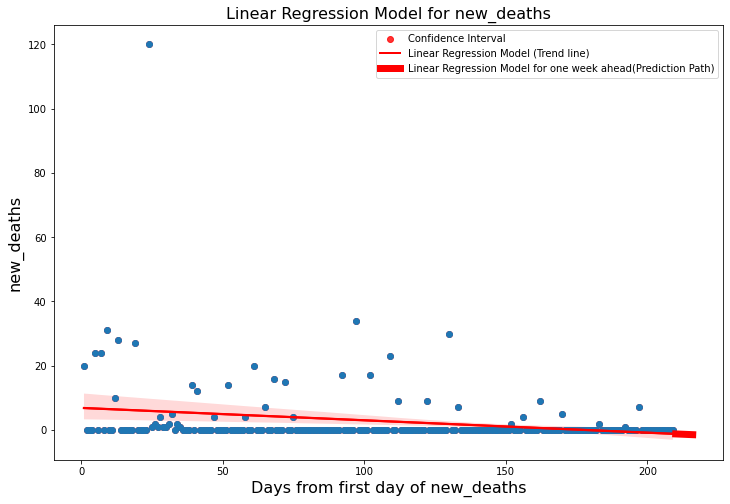

RMSE of Linear Regression on new_deaths 9.989131493774748


In [53]:
sb_X_deaths,sb_y_deaths = lr_model(sb_county_deaths,'first_day','new_deaths')

Polynomial Regression Model for the new_deaths across the San Bernardino County in the CA State from the degree 2 to 5

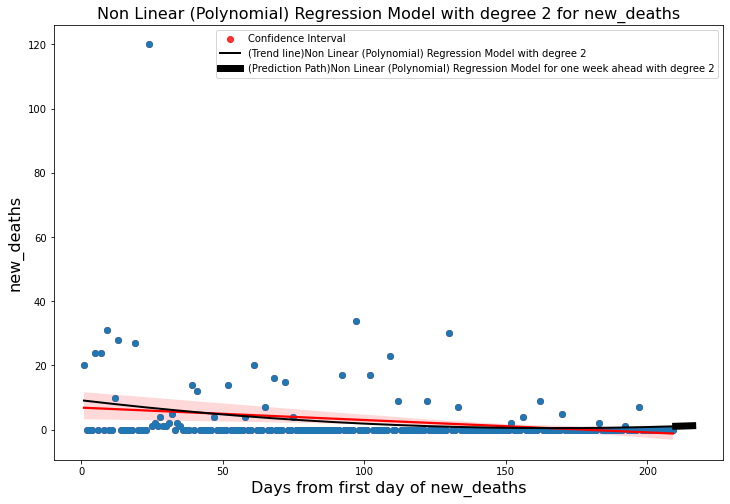

One week ahead forecast using Non-linear Regression Model with degree 2 [[1.06858854]
 [1.09560737]
 [1.12324791]
 [1.15151016]
 [1.18039412]
 [1.2098998 ]
 [1.24002719]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_deaths 9.937733685241428


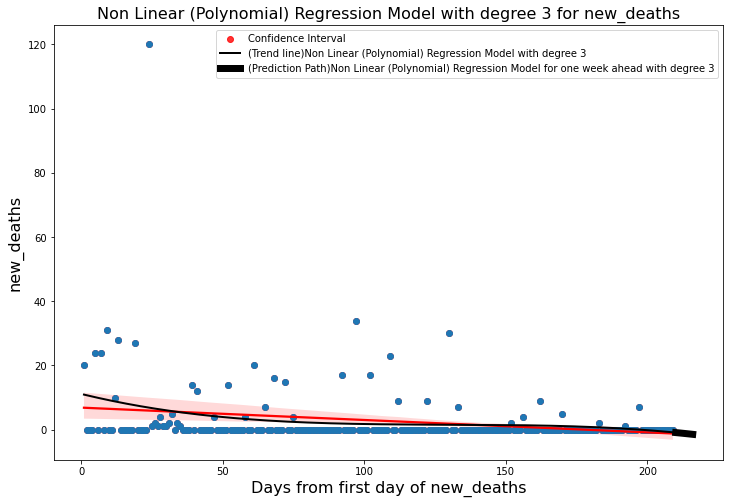

One week ahead forecast using Non-linear Regression Model with degree 3 [[-0.90493167]
 [-0.99068543]
 [-1.07848981]
 [-1.16837003]
 [-1.26035129]
 [-1.3544588 ]
 [-1.45071778]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_deaths 9.911266377056894


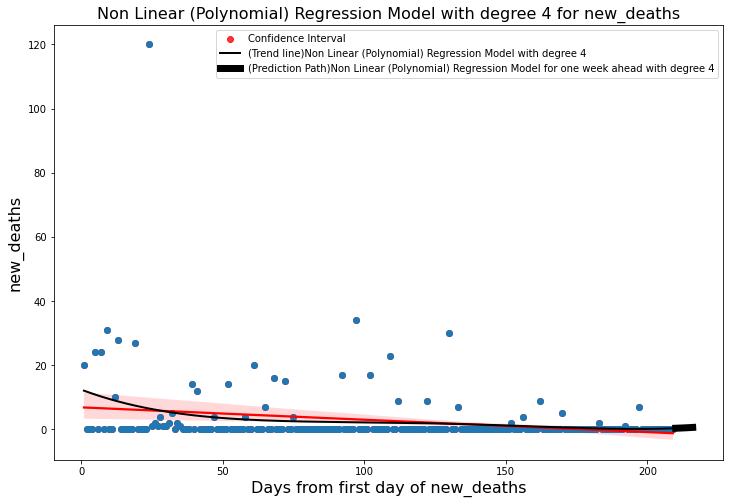

One week ahead forecast using Non-linear Regression Model with degree 4 [[0.36011912]
 [0.39484639]
 [0.43266203]
 [0.47365396]
 [0.51791116]
 [0.56552365]
 [0.61658255]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_deaths 9.903111254674823


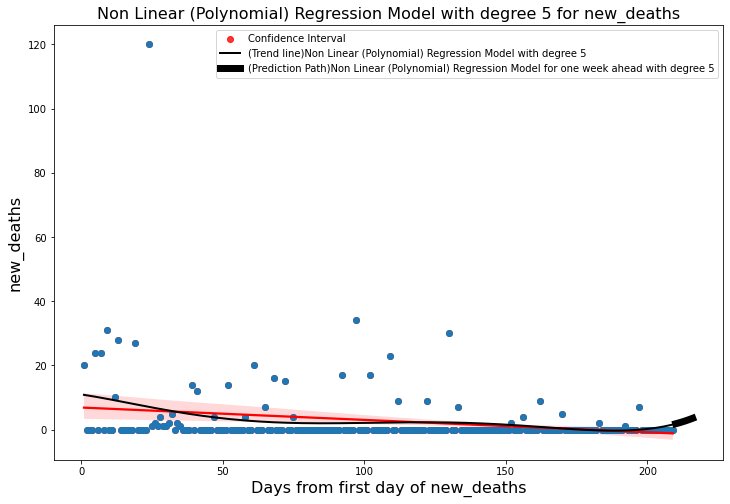

One week ahead forecast using Non-linear Regression Model with degree 5 [[1.80977768]
 [2.05159816]
 [2.31024779]
 [2.586333  ]
 [2.88047224]
 [3.19329609]
 [3.52544731]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_deaths 9.894751963390858


In [54]:
non_lr_model(sb_X_deaths,sb_y_deaths,[2,3,4,5],'new_deaths')

In [55]:
sc_county = selected_state_county_data_daily[selected_state_county_data_daily['countyFIPS']==6085]
sc_county

,countyFIPS,County Name,State,StateFIPS,Dates,cases,deaths,population,new_cases,new_deaths
8988,6085,Santa Clara County,CA,6,2022-06-01,351404,2303,1927852,1069.0,0.0
8989,6085,Santa Clara County,CA,6,2022-06-02,351517,2303,1927852,113.0,0.0
8990,6085,Santa Clara County,CA,6,2022-06-03,351517,2303,1927852,0.0,0.0
8991,6085,Santa Clara County,CA,6,2022-06-04,351517,2303,1927852,0.0,0.0
8992,6085,Santa Clara County,CA,6,2022-06-05,351517,2303,1927852,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9197,6085,Santa Clara County,CA,6,2022-12-27,461517,2570,1927852,154.0,0.0
9198,6085,Santa Clara County,CA,6,2022-12-28,461517,2570,1927852,0.0,0.0
9199,6085,Santa Clara County,CA,6,2022-12-29,461517,2570,1927852,0.0,0.0
9200,6085,Santa Clara County,CA,6,2022-12-30,461517,2570,1927852,0.0,0.0


In [56]:
sc_county['new_cases'].clip(lower=0, inplace = True) 
sc_county['new_deaths'].clip(lower=0, inplace = True)

In [57]:
sc_new_cases_list = sc_county['new_cases'].tolist()
sc_new_deaths_list = sc_county['new_deaths'].tolist()
sc_ind_cases,sc_first_day_cases = first_day_new_cases_deaths(sc_new_cases_list)
sc_county_cases = sc_county[['Dates','new_cases']]
sc_county_cases['first_day'] = sc_first_day_cases
sc_county_cases = sc_county_cases.iloc[sc_ind_cases:].reset_index(drop=True)
sc_county_cases

,Dates,new_cases,first_day
0,2022-06-01,1069.0,1
1,2022-06-02,113.0,2
2,2022-06-03,0.0,3
3,2022-06-04,0.0,4
4,2022-06-05,0.0,5
...,...,...,...
209,2022-12-27,154.0,210
210,2022-12-28,0.0,211
211,2022-12-29,0.0,212
212,2022-12-30,0.0,213


Linear Regression Model for the new_cases across the Santa Clara County in the CA State.

One week ahead forecast using Linear Regression Model = [[157.45425826]
 [153.94077038]
 [150.4272825 ]
 [146.91379461]
 [143.40030673]
 [139.88681885]
 [136.37333097]]


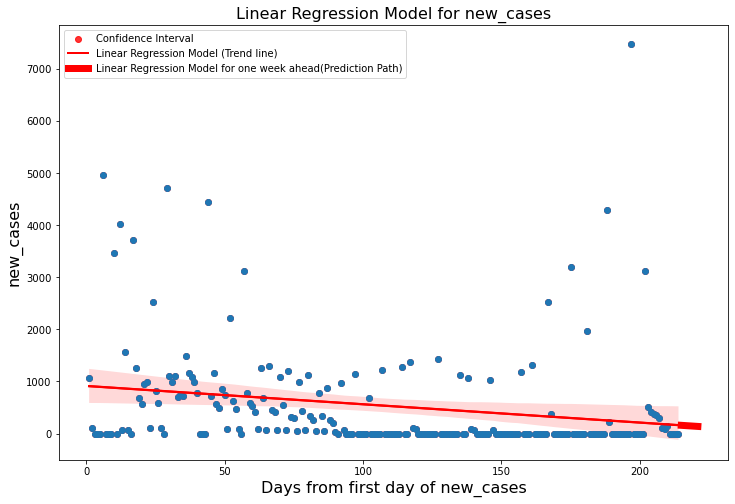

RMSE of Linear Regression on new_cases 1007.8667237164133


In [58]:
sc_X_cases,sc_y_cases = lr_model(sc_county_cases,'first_day','new_cases')

Polynomial Regression Model for the new_cases across the Santa Clara County in the CA State from the degree 2 to 5

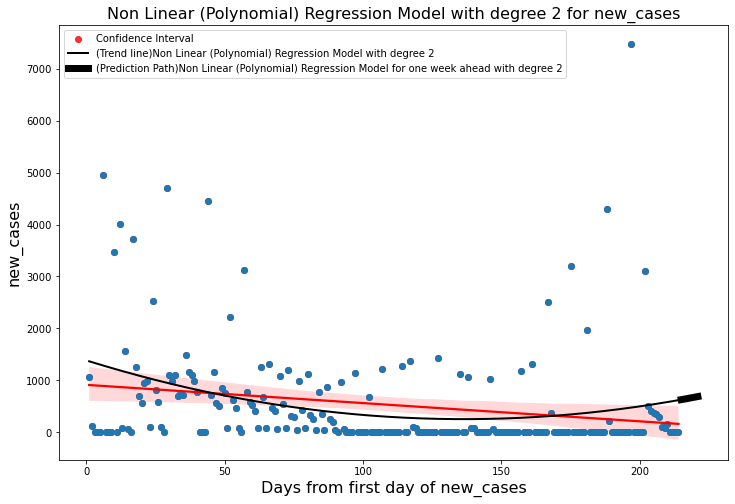

One week ahead forecast using Non-linear Regression Model with degree 2 [[627.77900164]
 [637.39085544]
 [647.12424017]
 [656.97915585]
 [666.95560246]
 [677.05358002]
 [687.27308852]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_cases 986.2948153147435


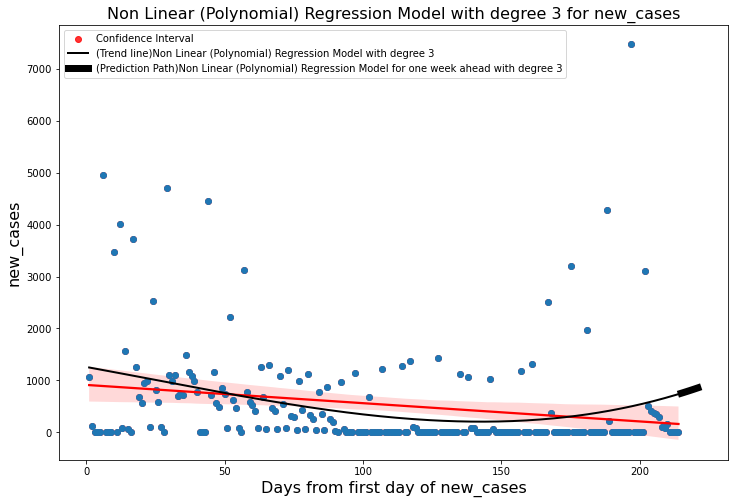

One week ahead forecast using Non-linear Regression Model with degree 3 [[752.57291337]
 [769.15000875]
 [786.00986752]
 [803.15397568]
 [820.58381925]
 [838.30088425]
 [856.30665669]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_cases 985.2278926344331


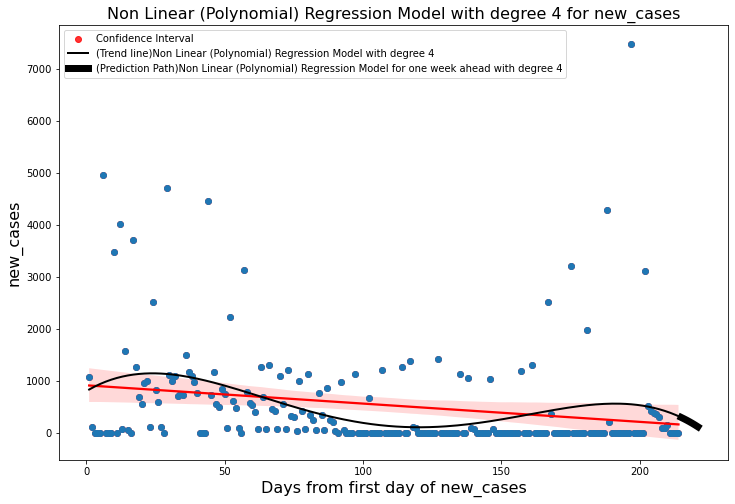

One week ahead forecast using Non-linear Regression Model with degree 4 [[294.66168036]
 [268.64238119]
 [241.13099562]
 [212.09084086]
 [181.48488393]
 [149.2757417 ]
 [115.42568083]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_cases 974.3997159371088


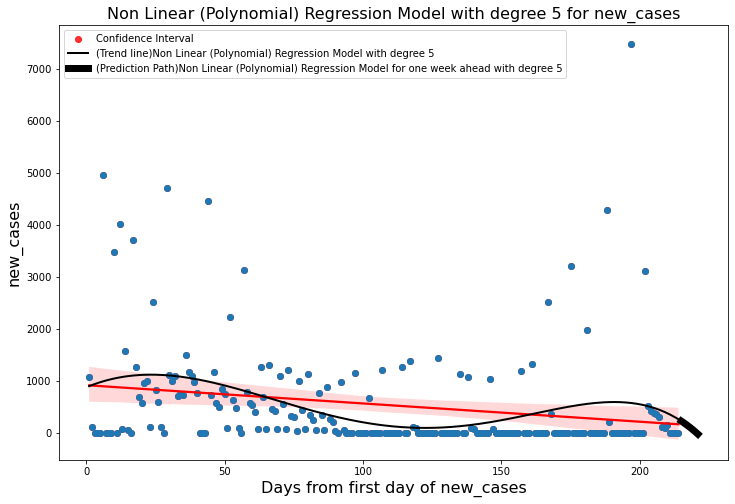

One week ahead forecast using Non-linear Regression Model with degree 5 [[222.24229572]
 [186.11793089]
 [147.84652136]
 [107.36723841]
 [ 64.6184047 ]
 [ 19.53748975]
 [-27.9388946 ]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_cases 974.187043419613


In [59]:
non_lr_model(sc_X_cases,sc_y_cases,[2,3,4,5],'new_cases')

In [60]:
sc_ind_deaths,sc_first_day_deaths = first_day_new_cases_deaths(sc_new_deaths_list)
sc_county_deaths = sc_county[['Dates','new_deaths']]
sc_county_deaths['first_day'] = sc_first_day_deaths
sc_county_deaths = sc_county_deaths.iloc[sc_ind_deaths:].reset_index(drop=True)
sc_county_deaths

,Dates,new_deaths,first_day
0,2022-06-06,4.0,1
1,2022-06-07,0.0,2
2,2022-06-08,0.0,3
3,2022-06-09,0.0,4
4,2022-06-10,0.0,5
...,...,...,...
204,2022-12-27,0.0,205
205,2022-12-28,0.0,206
206,2022-12-29,0.0,207
207,2022-12-30,0.0,208


Linear Regression Model for the new_deaths across the Santa Clara County in the CA State.

One week ahead forecast using Linear Regression Model = [[1.12937063]
 [1.12449656]
 [1.11962248]
 [1.11474841]
 [1.10987434]
 [1.10500026]
 [1.10012619]]


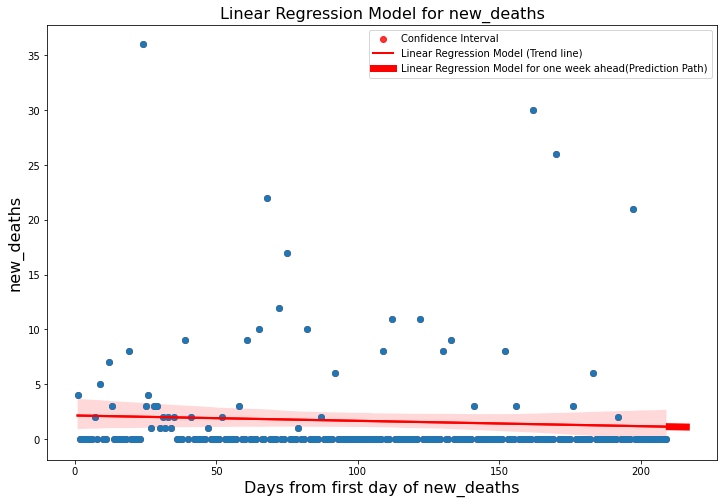

RMSE of Linear Regression on new_deaths 4.831125687630393


In [61]:
sc_X_deaths,sc_y_deaths = lr_model(sc_county_deaths,'first_day','new_deaths')

Polynomial Regression Model for the new_deaths across the Santa Clara County in the CA State for the degree 2 to 5

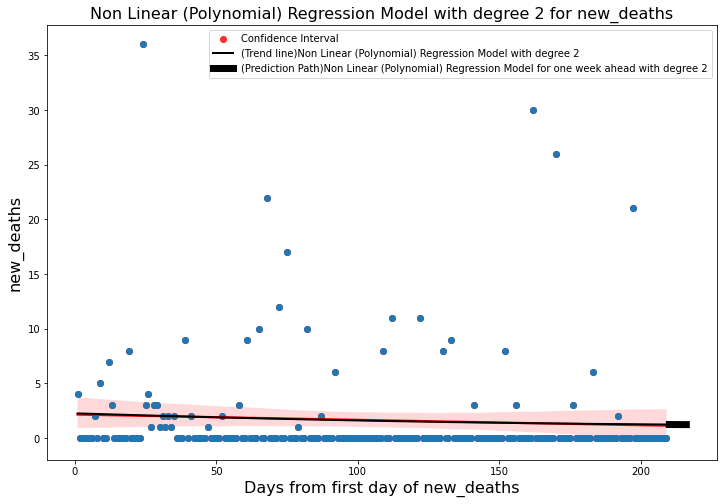

One week ahead forecast using Non-linear Regression Model with degree 2 [[1.24087335]
 [1.23918507]
 [1.23752699]
 [1.2358991 ]
 [1.23430141]
 [1.23273392]
 [1.23119662]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_deaths 4.830875615219205


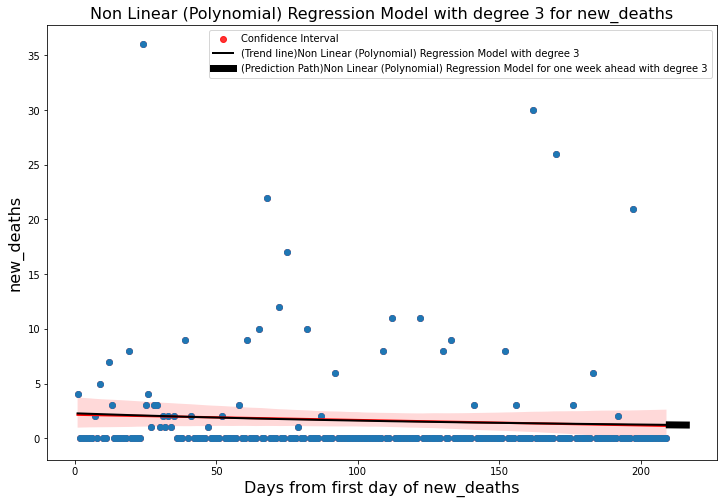

One week ahead forecast using Non-linear Regression Model with degree 3 [[1.22313901]
 [1.22043733]
 [1.21774184]
 [1.21505231]
 [1.21236851]
 [1.20969021]
 [1.20701719]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_deaths 4.8308712244563505


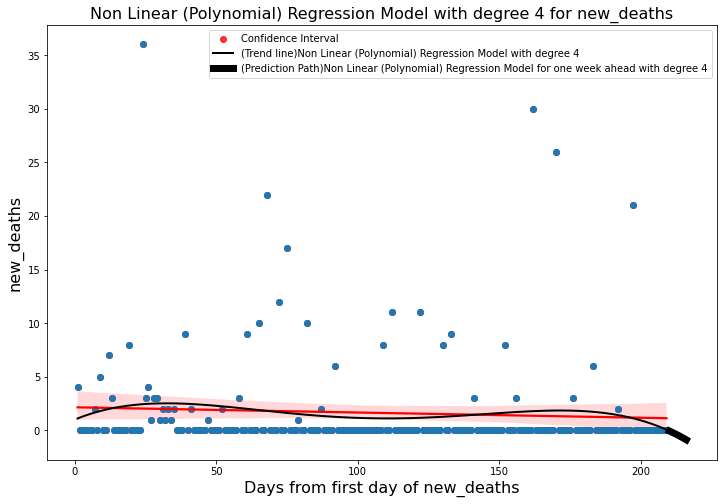

One week ahead forecast using Non-linear Regression Model with degree 4 [[-0.05562727]
 [-0.18011621]
 [-0.30979368]
 [-0.44477427]
 [-0.58517361]
 [-0.73110843]
 [-0.88269653]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_deaths 4.813751682540691


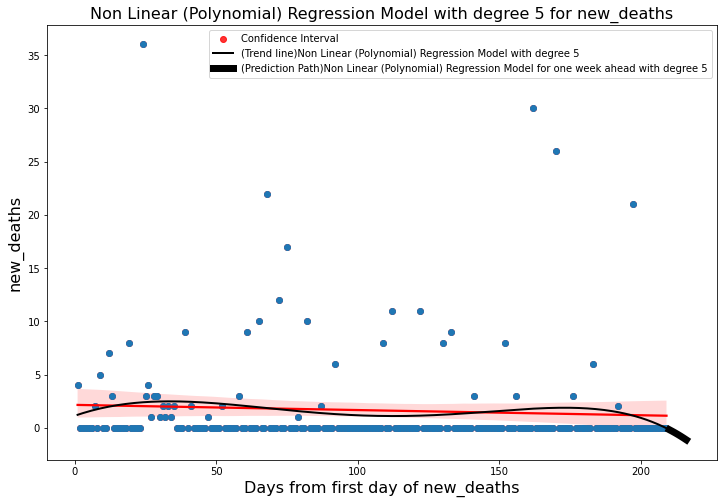

One week ahead forecast using Non-linear Regression Model with degree 5 [[-0.17905785]
 [-0.32117982]
 [-0.46966028]
 [-0.62465796]
 [-0.78633361]
 [-0.95484995]
 [-1.13037177]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_deaths 4.813627057051484


In [62]:
non_lr_model(sc_X_deaths,sc_y_deaths,[2,3,4,5],'new_deaths')

### Perform hypothesis tests on questions identified in Stage III

Reading the csv file of cases_deaths which is generated in the stage 3

In [63]:
cases_deaths = pd.read_csv('../../../../data/Stage_3/cases_deaths.csv')
cases_deaths

,State,Dates,countyFIPS,StateFIPS,cases,deaths,population,new_cases,new_deaths
0,AK,2020-01-22,62340,58,0,0,731545,NaN,NaN
1,AK,2020-01-23,62340,58,0,0,731545,0.0,0.0
2,AK,2020-01-24,62340,58,0,0,731545,0.0,0.0
3,AK,2020-01-25,62340,58,0,0,731545,0.0,0.0
4,AK,2020-01-26,62340,58,0,0,731545,0.0,0.0
...,...,...,...,...,...,...,...,...,...
55636,WY,2023-01-12,1288529,1288,183385,1967,578759,234.0,9.0
55637,WY,2023-01-13,1288529,1288,183385,1967,578759,0.0,0.0
55638,WY,2023-01-14,1288529,1288,183385,1967,578759,0.0,0.0
55639,WY,2023-01-15,1288529,1288,183385,1967,578759,0.0,0.0


Selecting the date range from june 1st 2022 to dec 31st 2022 as we performed analysis for the second half of the 2022

In [64]:
cases_deaths = cases_deaths[(cases_deaths['Dates'] >= '2022-06-01') & (cases_deaths['Dates'] < '2023-01-01')]
cases_deaths

,State,Dates,countyFIPS,StateFIPS,cases,deaths,population,new_cases,new_deaths
861,AK,2022-06-01,62340,58,244906,1231,731545,0.0,0.0
862,AK,2022-06-02,62340,58,244906,1231,731545,0.0,0.0
863,AK,2022-06-03,62340,58,244906,1231,731545,0.0,0.0
864,AK,2022-06-04,62340,58,244906,1231,731545,0.0,0.0
865,AK,2022-06-05,62340,58,244906,1231,731545,0.0,0.0
...,...,...,...,...,...,...,...,...,...
55620,WY,2022-12-27,1288529,1288,182581,1958,578759,0.0,0.0
55621,WY,2022-12-28,1288529,1288,182581,1958,578759,0.0,0.0
55622,WY,2022-12-29,1288529,1288,182581,1958,578759,0.0,0.0
55623,WY,2022-12-30,1288529,1288,182581,1958,578759,0.0,0.0


In [65]:
population = cases_deaths['population'].unique().tolist() #Getting the population of each state to a list

In [66]:
cases_deaths_sum = cases_deaths.groupby('State').sum().reset_index() #Grouping the above dataframe by State column
cases_deaths_sum.head(5)

,State,countyFIPS,StateFIPS,cases,deaths,population,new_cases,new_deaths
0,AK,13340760,12412,57302831,279095,156550630,32978.0,162.0
1,AL,15298646,14338,315397640,4329709,1049281590,253971.0,1073.0
2,AR,81453750,80250,192127203,2583876,645810056,136014.0,1207.0
3,AZ,12884512,12840,479635894,6388328,1557645438,327707.0,0.0
4,CA,75191896,74472,2178288181,20184942,8455615722,1910026.0,6936.0


In [67]:
covid_cases_deaths = cases_deaths_sum[['State','new_cases','new_deaths']] #selecting the required columns
covid_cases_deaths['Total Population'] = population #Adding the Total population of the state
#Renaming the new cases and new deaths column
covid_cases_deaths.rename(columns={'new_cases':'Total Cases','new_deaths':'Total Deaths'},inplace = True)
covid_cases_deaths.head(5)

,State,Total Cases,Total Deaths,Total Population
0,AK,32978.0,162.0,731545
1,AL,253971.0,1073.0,4903185
2,AR,136014.0,1207.0,3017804
3,AZ,327707.0,0.0,7278717
4,CA,1910026.0,6936.0,39512223


Reading the census_demographic csv file generated in the stage 1

In [68]:
census_demographic= pd.read_csv('../../../../data/Stage_1/census_demographic.csv')
census_demographic

,countyFIPS,County Name,State,Male population,Female population,Under 5years,5 to 9years,10 to 14years,15 to 19years,20 to 24years,...,Male(65years and above),Female(65years and over),One race population,White population,Black population,Asian population,Total Housing units,Voting population,Male voting population,Female voting population
0,1001,Autauga County,AL,28206,30033,3318,3716,4004,3939,3648,...,3919,4896,56166,43755,11470,647,24170,43906,21018,22888
1,1003,Baldwin County,AL,110781,116350,12035,11730,16407,13801,11181,...,21795,25010,219535,192034,19895,2175,121763,174686,83847,90839
2,1005,Barbour County,AL,13361,11898,1320,1601,1422,1487,1434,...,2084,2717,24641,11495,11985,106,11667,19623,10571,9052
3,1007,Bibb County,AL,12300,10112,1196,1274,1230,1463,1192,...,1629,1965,22111,17020,5003,46,9013,17682,9690,7992
4,1009,Blount County,AL,29530,29354,3467,3578,4194,3591,3386,...,4726,5858,56921,54439,760,216,24527,43633,21535,22098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,56037,Sweetwater County,WY,21850,20609,2657,3456,3008,3017,2505,...,2608,2782,39597,36867,525,487,19174,30055,15515,14540
3139,56039,Teton County,WY,12280,11039,1068,1032,1475,1144,941,...,1829,1780,22643,19873,166,369,13255,17273,9135,8138
3140,56041,Uinta County,WY,10437,10077,1413,1712,1762,1327,1067,...,1540,1482,19536,18899,52,37,8819,14203,7206,6997
3141,56043,Washakie County,WY,4004,3764,399,321,606,633,386,...,824,906,7328,6655,1,31,3842,5993,3013,2980


In [69]:
#Grouping the above dataframe by State column
census_demographic_grouped = census_demographic.groupby('State').sum().reset_index()
census_demographic_grouped.head(5)

,State,countyFIPS,Male population,Female population,Under 5years,5 to 9years,10 to 14years,15 to 19years,20 to 24years,25 to 34years,...,Male(65years and above),Female(65years and over),One race population,White population,Black population,Asian population,Total Housing units,Voting population,Male voting population,Female voting population
0,AK,64208,384749,351202,50791,53270,49647,47081,50780,116525,...,45027,45161,662005,458520,23721,47213,324434,532632,281085,251547
1,AL,71489,2429703,2567972,295632,301814,329794,329732,326900,647247,...,372139,472288,4842360,3338590,1324233,70161,2278526,3782980,1806826,1976154
2,AR,380625,1483520,1522789,184580,195648,203248,203530,198013,388499,...,226725,278636,2847206,2227020,458086,46388,1361880,2211566,1072583,1138983
3,AZ,60208,3533895,3545308,412606,440221,480043,476470,477856,966670,...,576938,666921,6344182,4985729,318827,234495,3056890,5000102,2476974,2523128
4,CA,351364,19714044,19741309,2350335,2434113,2658361,2588625,2626849,5941622,...,2549526,3120353,35220136,20553732,2233258,5887396,14328539,25916215,12796956,13119259


Selecting the required columns from all the columns

In [70]:
census_demographic_final = census_demographic_grouped[['State','Male population','Female population','18years and above','65years and above',
                                          'White population','Black population','Asian population']]
census_demographic_final.head(5)

,State,Male population,Female population,18years and above,65years and above,White population,Black population,Asian population
0,AK,384749,351202,553217,90188,458520,23721,47213
1,AL,2429703,2567972,3875294,844427,3338590,1324233,70161
2,AR,1483520,1522789,2300524,505361,2227020,458086,46388
3,AZ,3533895,3545308,5464768,1243859,4985729,318827,234495
4,CA,19714044,19741309,30462921,5669879,20553732,2233258,5887396


Merging the covid_cases_deaths dataframe and census_demographic_final dataframe on the State column

In [71]:
covid_census_merged = pd.merge(covid_cases_deaths,census_demographic_final,on = ['State'])
covid_census_merged.head(5)

,State,Total Cases,Total Deaths,Total Population,Male population,Female population,18years and above,65years and above,White population,Black population,Asian population
0,AK,32978.0,162.0,731545,384749,351202,553217,90188,458520,23721,47213
1,AL,253971.0,1073.0,4903185,2429703,2567972,3875294,844427,3338590,1324233,70161
2,AR,136014.0,1207.0,3017804,1483520,1522789,2300524,505361,2227020,458086,46388
3,AZ,327707.0,0.0,7278717,3533895,3545308,5464768,1243859,4985729,318827,234495
4,CA,1910026.0,6936.0,39512223,19714044,19741309,30462921,5669879,20553732,2233258,5887396


1) Null Hypothesis: Spread of covid-19 cases increases with increase in white population.

Alternative Hypothesis: Spread of covid-19 cases is independent with increase in white population

Applying the two tail two sample t-test then the obtained t-statistic value and pvalue

In [72]:
stats.ttest_ind(a= covid_census_merged['Total Cases'],b= covid_census_merged['White population'] )

Ttest_indResult(statistic=-6.741883169759876, pvalue=1.0194921140284972e-09)

From the above result we can see that the pvalue is less than the threshold value i.e., 0.05 so we can reject the null hypothesis.

Applying the one tail two sample t-test to know a is greater or lesser than b.

From the above result we can observe that p/2 < threshold and t-statistic value is less than zero(<0). So a is less than b (i.e., a lies on the lower side)

2) Null Hypothesis: Covid cases are more in the age group of 65 years and above.

Alternative Hypothesis: Covid cases are less in the age group of 65 years and above

Applying the two tail two sample t-test then the obtained t-statistic value and pvalue

In [73]:
stats.ttest_ind(a= covid_census_merged['Total Cases'],b= covid_census_merged['65years and above'] )

Ttest_indResult(statistic=-4.794461946237647, pvalue=5.691252463158576e-06)

From the above result we can see that the pvalue is less than the threshold value i.e., 0.05 so we can reject the null hypothesis.

Applying the one tail two sample t-test to know a is greater or lesser than b.

From the above result we can observe that p/2 < threshold and t-statistic value is less than zero(<0). So a is less than b (i.e., a lies on the lower side)

3) Null Hypothesis: Covid cases spread is more in male population.

Alternative Hypothesis: Covid cases spread is independent with the male population.

Applying the two tail two sample t-test then the obtained t-statistic value and pvalue

In [74]:
stats.ttest_ind(a= covid_census_merged['Total Cases'],b= covid_census_merged['Male population'] )

Ttest_indResult(statistic=-5.740019144470273, pvalue=1.0177148085197161e-07)

From the above result we can see that the pvalue is less than the threshold value i.e., 0.05 so we can reject the null hypothesis.

Applying the one tail two sample t-test to know a is greater or lesser than b.

From the above result we can observe that p/2 < threshold and t-statistic value is less than zero(<0). So a is less than b (i.e., a lies on the lower side)

4) Null Hypothesis: Covid cases spread is more in Asian population

Alternative Hypothesis: Covid cases spread is independent with asian population.

Applying the two tail two sample t-test then the obtained t-statistic value and pvalue

In [75]:
stats.ttest_ind(a= covid_census_merged['Total Cases'],b= covid_census_merged['Asian population'] )

Ttest_indResult(statistic=-0.9477950950698217, pvalue=0.34551857401262087)

From the above result we can see that the pvalue is greater than the threshold value i.e., 0.05. So we failed to reject the null hypothesis. It falls into type II error as we failed to null hypothesis but the null hypothesis itself is false.

My enrichment dataset doesnot fall in the category where we can apply the chi-squared test. So used two tail two sample ttest and one tail two sample ttest for the hypothesis testing.

References:

- https://stackoverflow.com/questions/16396903/delete-the-first-three-rows-of-a-dataframe-in-pandas

- https://stackoverflow.com/questions/26921651/how-to-delete-the-last-row-of-data-of-a-pandas-dataframe

- https://stackoverflow.com/questions/41328922/python-pandas-simple-example-of-calculating-rmse-from-data-frame

- https://stackoverflow.com/questions/64998713/i-want-to-delete-specific-dates-from-a-column-in-pandas

- https://www.analyticsvidhya.com/blog/2020/03/polynomial-regression-python/

- https://www.askpython.com/python/examples/polynomial-regression-in-python

- https://www.statology.org/plot-confidence-interval-python/

